In [49]:
! pip install tflearn

from pandas_datareader import data
import matplotlib.pyplot as plt
from abc import ABC
from pprint import pprint
import gym
import gym.spaces
import numpy as np
import pandas as pd
import traceback
import csv
import os
import random
from collections import deque
import tensorflow as tf
import tflearn
import math
from scipy import stats

In [50]:
os.environ["KERAS_BACKEND"] = "tensorflow"
os.environ['DISABLE_COLAB_TF_IMPORT_HOOK'] = '1'
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('没有发现GPU device')
# print('Found GPU at: {}'.format(device_name))
# tf.config.experimental.list_physical_devices('GPU')
# %load_ext autoreload
# %autoreload 2
if 'COLAB_TPU_ADDR' not in os.environ:
    print('ERROR: Not connected to a TPU runtime')
else:
    tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']
    print ('TPU address is', tpu_address)

ERROR: Not connected to a TPU runtime


In [51]:
# # tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
# cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://10.56.229.58:8470') 
# tf.config.experimental_connect_to_cluster(cluster_resolver) 
# tf.tpu.experimental.initialize_tpu_system(cluster_resolver) 
# tpu_strategy = tf.distribute.experimental.TPUStrategy(cluster_resolver)
# # tf.config.experimental_connect_to_cluster(tpu)
# # tf.tpu.experimental.initialize_tpu_system(tpu)
# # strategy = tf.distribute.experimental.TPUStrategy(tpu)

# data process

---


In [52]:
def data_process(symbols, start_date, end_date):
	panel_data = data.DataReader(symbols, "yahoo", start_date, end_date)
	dataset = pd.DataFrame(data=panel_data)

	suffix = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']

	out = np.empty((len(symbols), len(dataset), 6))

	for i_n, i in enumerate(symbols):
		for j_n, j in enumerate(suffix):
			out[i_n, :, j_n] = dataset[(j, i)]

	return out

# Tools

In [53]:
eps = 1e-20
DEBUG = False


# Max 10 day drop down
def maximum_10_drawdown(returns):
	max_dd = 0
	for i in range(len(returns) - 10):
		ten_day = returns[i:i + 10]
		max_ = np.max(ten_day)
		min_ = np.min(ten_day)
		dd_10 = (max_ - min_) / min_
		max_dd = np.max(np.array([dd_10, max_dd]))
	return max_dd


def sample_para_VaR(data):
	VaR_5 = np.percentile(data, 5)
	return VaR_5


def insert_series(series):
	new_series = [i for i in range(len(series))]
	n = len(series)
	steps = int(n / 5)
	ranges = list(np.arange(0, len(series), step=steps))
	for i in range(len(new_series)):
		if i in ranges:
			new_series[i] = series[i]
		else:
			new_series[i] = ''
			if i == n - 1:
				new_series[i] = series[i]
	return new_series


# df
def output_statistics(strategy, benchmark):
	strategy_cum = (np.cumprod(np.array(strategy) + 1)) - 1
	benchmark_cum = (np.cumprod(np.array(benchmark))) - 1
	PnL = [strategy_cum[-1], benchmark_cum[-1]]
	average_return = [np.mean(strategy), np.mean(benchmark)-1]
	standard_deviation = [np.std(strategy), np.std(benchmark)]
	max_DD = [maximum_10_drawdown(strategy_cum + 1), maximum_10_drawdown(benchmark_cum + 1)]
	skewness = [stats.skew(strategy), stats.skew(benchmark)]
	kurtosis = [stats.kurtosis(strategy), stats.kurtosis(benchmark)]
	VaR = [sample_para_VaR(strategy), sample_para_VaR([i-1 for i in benchmark])]
	out_df = pd.DataFrame([PnL, average_return, standard_deviation,
						   max_DD, skewness, kurtosis, VaR])
	out_df.columns = ['strategy', 'benchmark']
	out_df.index = ['PnL', 'Daily Mean Arithmetic', 'Volatility', 'Max 10 days draw down', 'Skewness', 'Kurtosis', 'VaR']
	return out_df


def get_model_path(window_length, predictor_type, use_batch_norm):
	if use_batch_norm:
		batch_norm_str = 'batch_norm'
	else:
		batch_norm_str = 'no_batch_norm'
	return 'weights/stock/{}/window_{}/{}/checkpoint.ckpt'.format(predictor_type, window_length, batch_norm_str)


def get_result_path(window_length, predictor_type, use_batch_norm):
	if use_batch_norm:
		batch_norm_str = 'batch_norm'
	else:
		batch_norm_str = 'no_batch_norm'
	return 'results/stock/{}/window_{}/{}/'.format(predictor_type, window_length, batch_norm_str)


def get_variable_scope(window_length, predictor_type, use_batch_norm):
	if use_batch_norm:
		batch_norm_str = 'batch_norm'
	else:
		batch_norm_str = 'no_batch_norm'
	return '{}_window_{}_{}'.format(predictor_type, window_length, batch_norm_str)


def stock_predictor(inputs, predictor_type, use_batch_norm):
  window_length = inputs.get_shape()[2]
  assert predictor_type in ['cnn', 'lstm'], 'type must be either cnn or lstm'
  if predictor_type == 'cnn':
    net = tflearn.conv_2d(inputs, 16, (1, 3), padding='valid')
    if use_batch_norm:
      net = tflearn.layers.normalization.batch_normalization(net)
    net = tflearn.activations.relu(net)
    net = tflearn.conv_2d(net, 16, (1, window_length - 2), padding='valid')
    if use_batch_norm:
      net = tflearn.layers.normalization.batch_normalization(net)
    net = tflearn.activations.relu(net)
    if DEBUG:
      print('After conv2d:', net.shape)
    net = tflearn.flatten(net)
    if DEBUG:
      print('Output:', net.shape)
  elif predictor_type == 'lstm':
    num_stocks = inputs.get_shape()[1]
    hidden_dim = 16
    net = tflearn.reshape(inputs, new_shape=[-1, window_length, 3])
    if DEBUG:
      print('Reshaped input:', net.shape)
    net = tflearn.lstm(net, hidden_dim)
    if DEBUG:
      print('After LSTM:', net.shape)
    net = tflearn.reshape(net, new_shape=[-1, num_stocks, hidden_dim])
    if DEBUG:
      print('After reshape:', net.shape)
    net = tflearn.flatten(net)
    if DEBUG:
      print('Output:', net.shape)
  else:
    raise NotImplementedError

  return net


def obs_normalizer(observation):
	if isinstance(observation, tuple):
		observation = observation[0]
	# directly use close/open ratio as feature
	obs_price_ratio = (observation[:, :, 1] / observation[:, :, 4]) - 1
	obs_volume_ratio = (observation[:, :, 5] - np.mean(observation[:, :, 5])) / np.std(observation[:, :, 5])
	obs_amp = (observation[:, :, 2] - observation[:, :, 3]) / observation[:, :, 4]
	observation = np.concatenate((np.expand_dims(obs_price_ratio, axis=2),
								  np.expand_dims(obs_volume_ratio, axis=2),
								  np.expand_dims(obs_amp, axis=2)), axis=2)
	return observation


def test_model(env, model):
  
  with tf.device('/GPU:0'):
    observation, info = env.reset()
    done = False
    while not done:
      action = model.predict_single(observation)
      observation, reward, done, info = env.step(action)

    env.render()


# Buffer

In [54]:
class ReplayBuffer(object):
	def __init__(self, buffer_size, random_seed=123):
		"""
		The right side of the deque contains the most recent experiences
		"""
		self.buffer_size = buffer_size
		self.count = 0
		self.buffer = deque()
		random.seed(random_seed)

	def add(self, s, a, r, t, s2):
		experience = (s, a, r, t, s2)
		if self.count < self.buffer_size:
			self.buffer.append(experience)
			self.count += 1
		else:
			self.buffer.popleft()
			self.buffer.append(experience)

	def size(self):
		return self.count

	def sample_batch(self, batch_size):
		if self.count < batch_size:
			batch = random.sample(self.buffer, self.count)
		else:
			batch = random.sample(self.buffer, batch_size)

		s_batch = np.array([_[0] for _ in batch])
		a_batch = np.array([_[1] for _ in batch])
		r_batch = np.array([_[2] for _ in batch])
		t_batch = np.array([_[3] for _ in batch])
		s2_batch = np.array([_[4] for _ in batch])

		return s_batch, a_batch, r_batch, t_batch, s2_batch

	def clear(self):
		self.buffer.clear()
		self.count = 0

	def store(self):
		data_folder = "/buffer_data"
		if not os.path.exists(data_folder):
			os.makedirs(data_folder)

		# Write screen features
		data_path = data_folder + '/' + 'experience_replay' + '.txt'
		mode = 'a+' if os.path.exists(data_path) else 'w+'
		with open(data_path, mode, newline='') as f:
			writer = csv.writer(f)
			writer.writerows(self.buffer)

	def restore(self, data_path):
		with open(data_path, 'r') as f:
			self.buffer = [line[:-1].strip('""') for line in f]
		return self.buffer


# Environment

In [55]:
from abc import ABC
from pprint import pprint
import gym.spaces
import numpy as np
import pandas as pd

eps = 1e-20


class DataGenerator(object):
	def __init__(self, history, abbreviation, steps=120, window_length=50):
		assert history.shape[0] == len(abbreviation), 'Number of stock is not consistent'
		import copy

		self.steps = steps + 1
		self.window_length = window_length
		self._data = history.copy()  # all data
		self.asset_names = copy.copy(abbreviation)
		self.step = 0
		self.idx = None
		self.data = None

	def step_(self):
		# get observation matrix from history
		# the stock data were observed every day
		self.step += 1
		obs = self.data[:, self.step:(self.step + self.window_length), :].copy()

		# used for compute optimal action and sanity check
		ground_truth_obs = self.data[:, (self.step + self.window_length):(self.step + self.window_length + 1), :].copy()

		done = (self.step + 1 >= self.steps)
		return obs, done, ground_truth_obs

	def step_sim(self):
		# get observation without stepping forward
		obs = self.data[:, self.step:(self.step + self.window_length), :].copy()

		# used for compute optimal action and sanity check
		ground_truth_obs = self.data[:, (self.step + self.window_length):(self.step + self.window_length + 1), :].copy()

		done = (self.step + 1 >= self.steps)

		return obs, done, ground_truth_obs

	def reset(self):
		self.step = 0

		# get data for this episode, each episode might be different.
		self.idx = np.random.randint(
			low=self.window_length, high=self._data.shape[1] - self.steps)

		data = self._data[:, (self.idx - self.window_length):(self.idx + self.steps + 2), :]
		# apply augmentation?
		self.data = data

		return self.data[:, self.step:(self.step + self.window_length), :].copy(), \
			   self.data[:, (self.step + self.window_length):(self.step + self.window_length + 1), :].copy()


class PortfolioSim(object):
	"""
	Portfolio management simyulation.
	Based of [Jiang 2017](https://arxiv.org/abs/1706.10059)
	"""

	def __init__(self, asset_names: list, returns_list: list, steps=730, trading_cost=0.0025, time_cost=0.0):
		self.asset_names = asset_names
		self.returns_list = returns_list
		self.cost = trading_cost
		self.time_cost = time_cost
		self.steps = steps
		self.infos = []
		self.w0 = None
		self.p0 = 1.0

	def step(self, w1, y1, Sigma):
		"""
		Step.
		w1 - new action of portfolio weights
		y1 - vector of percentage price change(daily)
		"""
		assert w1.shape == y1.shape, 'w1 and y1 must have the same shape'
		assert y1[0] == 1.0, 'y1[0] must be 1'

		w0 = self.w0
		p0 = self.p0
		n_assets = len(self.asset_names)

		dw1 = (y1 * w0) / (np.dot(y1, w0) + eps)  # weights at the end of the period (prices change, weight change)

		cost = self.cost * (np.abs(dw1[1:] - w1[1:])).sum()  # cost to change portfolio

		assert cost < 1.0, 'Cost is larger than current holding'

		p1 = p0 * (1 - cost) * np.dot(y1, dw1)

		rho1 = p1 / p0 - 1  # rate of returns

		r1 = np.log((p1 + eps) / (p0 + eps))  # log return

		reward = r1
		if rho1 >= 0.002:
			reward *= 1.015
		elif rho1 <= -0.005:
			reward *= 0.99

		# remember for next step
		self.p0 = p1
		self.w0 = w1

		# if we run out of money, we're done (losing all the money)
		done = (p1 == 0)

		info = {
			"reward": reward,
			"log_return": r1,
			"portfolio_value": p1,
			"return": y1.mean(),
			"rate_of_return": rho1,
			"weights_mean": w1.mean(),
			"weights_std": w1.std(),
			"weights": np.round(w1, 4),
			"cost": cost,
			"price_change": y1

		}
		self.infos.append(info)
		return reward, info, done

	def reset(self):
		self.infos = []
		self.w0 = np.array([1.0] + [0.0] * len(self.asset_names))
		self.p0 = 1.0


class PortfolioEnv(gym.Env, ABC):
	"""
	An environment for financial portfolio management.
	"""
	def __init__(self,
				 history,
				 abbreviation,
				 steps=120,
				 trading_cost=0.0025,
				 time_cost=0.00,
				 window_length=15,
				 start_idx=0):
		"""
		An environment for financial portfolio management.
		Params:
			steps - steps in episode
			scale - scale data and each episode (except return)
			augment - fraction to randomly shift data by
			trading_cost - cost of trade as a fraction
			time_cost - cost of holding as a fraction
			window_length - how many past observations to return
			start_idx - The number of days from '2018-01-02' of the dataset
		"""
		self.window_length = window_length
		self.num_stocks = history.shape[0]
		self.start_idx = start_idx

		self.src = DataGenerator(history, abbreviation, steps=steps, window_length=window_length)

		self.sim = PortfolioSim(
			asset_names=abbreviation,
			returns_list=history,
			trading_cost=trading_cost,
			time_cost=time_cost,
			steps=steps)

	def step(self, action: pd.Series, simulation=0):
		return self._step(action, simulation)

	def _step(self, action, simulation):
		"""
		Step the env.
		Actions should be portfolio [w0...]
		- Where wn is a portfolio weight from 0 to 1. The first is cash_bias
		- cn is the portfolio conversion weights see PortioSim._step for description
		"""
		np.testing.assert_almost_equal(
			action.shape,
			(len(self.sim.asset_names) + 1,)
		)

		weights = action

		assert ((action >= 0) * (action <= 1)).all(), 'all action values should be between 0 and 1. Not %s' % action
		np.testing.assert_almost_equal(
			np.sum(weights), [1.0], 3, err_msg='weights should sum to 1. action="%s"' % weights)

		if simulation == 0:
			observation, done1, ground_truth_obs = self.src.step_()
		else:
			observation, done1, ground_truth_obs = self.src.step_sim()

		# concatenate observation with ones
		cash_observation = np.ones((1, self.window_length, observation.shape[2]))
		observation = np.concatenate((cash_observation, observation), axis=0)
		cash_ground_truth = np.ones((1, 1, ground_truth_obs.shape[2]))
		ground_truth_obs = np.concatenate((cash_ground_truth, ground_truth_obs), axis=0)
  
		# relative price vector of last observation day (close/open)
		current_open_price_vector = observation[:, -1, 4]
		last_open_price_vector = observation[:, -2, 4]

		y1 = current_open_price_vector / last_open_price_vector

		Sigma = pd.DataFrame(observation[1:, :, 0]).apply(np.std, axis=1)

		reward, info, done2 = self.sim.step(weights, y1, Sigma)

		# calculate return for buy and hold a bit of each asset
		if simulation == 0:
			info['market_value'] = np.cumprod([inf["return"] for inf in self.infos + [info]])[-1]
			info['date'] = self.start_idx + self.src.idx + self.src.step
			info['steps'] = self.src.step
			info['next_obs'] = ground_truth_obs
			self.infos.append(info)

		return observation, reward, done1 or done2, info

	def reset(self):
		return self._reset()

	def _reset(self):
		self.infos = []
		self.sim.reset()
		observation, ground_truth_obs = self.src.reset()
		cash_observation = np.ones((1, self.window_length, observation.shape[2]))
		observation = np.concatenate((cash_observation, observation), axis=0)
		cash_ground_truth = np.ones((1, 1, ground_truth_obs.shape[2]))
		ground_truth_obs = np.concatenate((cash_ground_truth, ground_truth_obs), axis=0)
		info = {'next_obs': ground_truth_obs}
		return observation, info

	def _render(self, mode='ansi', close=False):
		if close:
			return
		if mode == 'ansi':
			pprint(self.infos[-1])

	def render(self, mode='human', close=False):
		return self._render(mode='human', close=False)


# Action

In [56]:

class ActorNetwork:
    """
    Input to the network is the state, output is the action under a deterministic policy.
    The output layer activation is a tanh to keep the action in bounds
    """

    def __init__(self, sess, state_dim, action_dim, action_bound, learning_rate, tau, batch_size):
        """
        Args:
            sess: a tensorflow session
            state_dim: a list specifies shape
            action_dim: a list specified action shape
            action_bound: whether to normalize action in the end
            learning_rate: learning rate
            tau: target network update parameter
            batch_size: use for normalization
        """
        self.sess = sess
        assert isinstance(state_dim, list), 'state_dim must be a list.'
        self.s_dim = state_dim
        # print(self.s_dim)
        assert isinstance(action_dim, list), 'action_dim must be a list.'
        self.a_dim = action_dim
        self.action_bound = action_bound
        self.learning_rate = learning_rate
        self.tau = tau
        self.batch_size = batch_size

        # Actor Network
        self.inputs, self.out, self.scaled_out = self.create_actor_network()

        self.network_params = tf.compat.v1.trainable_variables()

        # Target Network
        self.target_inputs, self.target_out, self.target_scaled_out = self.create_actor_network()

        self.target_network_params = tf.compat.v1.trainable_variables()[
                                     len(self.network_params):]

        # Op for periodically updating target network with online network
        # weights
        self.update_target_network_params = \
            [self.target_network_params[i].assign(tf.multiply(self.network_params[i], self.tau) 
            + tf.multiply(self.target_network_params[i], 1. - self.tau))
            for i in range(len(self.target_network_params))]

        # This gradient will be provided by the critic network
        self.action_gradient = tf.compat.v1.placeholder(tf.float32, [None] + self.a_dim)

        # Combine the gradients here
        self.unnormalized_actor_gradients = tf.gradients(
            self.scaled_out, self.network_params, -self.action_gradient)
        self.actor_gradients = list(
            map(lambda x: tf.compat.v1.div(x, self.batch_size), self.unnormalized_actor_gradients))

        # Optimization Op
        self.optimize = tf.compat.v1.train.AdamOptimizer(self.learning_rate). \
            apply_gradients(zip(self.actor_gradients, self.network_params))

        self.num_trainable_vars = len(self.network_params) + len(self.target_network_params)

    def create_actor_network(self):
        raise NotImplementedError('Create actor should return (inputs, out, scaled_out)')

    def train(self, inputs, a_gradient):
        self.sess.run(self.optimize, feed_dict={
            self.inputs: inputs,
            self.action_gradient: a_gradient
        })

    def predict(self, inputs):
        return self.sess.run(self.scaled_out, feed_dict={
            self.inputs: inputs
        })

    def predict_target(self, inputs):
        return self.sess.run(self.target_scaled_out, feed_dict={
            self.target_inputs: inputs
        })

    def update_target_network(self):
        self.sess.run(self.update_target_network_params)

    def get_num_trainable_vars(self):
        return self.num_trainable_vars


class StockActor(ActorNetwork):
    def __init__(self, sess, state_dim, action_dim, action_bound, learning_rate, tau, batch_size,
                 predictor_type, use_batch_norm):
        self.predictor_type = predictor_type
        self.use_batch_norm = use_batch_norm
        ActorNetwork.__init__(self, sess, state_dim, action_dim, action_bound, learning_rate, tau, batch_size)

    def create_actor_network(self):
        """
        self.s_dim: a list specifies shape
        """
        nb_classes, window_length, features = self.s_dim
        assert window_length > 2, 'This architecture only support window length larger than 2.'

        inputs = tflearn.input_data(shape=[None] + self.s_dim, name='input')

        net = stock_predictor(inputs, self.predictor_type, self.use_batch_norm)

        net = tflearn.fully_connected(net, 16, activation='relu')
        if self.use_batch_norm:
            net = tflearn.layers.normalization.batch_normalization(net)
        net = tflearn.activations.tanh(net)
        w_init = tflearn.initializations.normal(mean=1/self.a_dim[0], stddev=0.8)
        out = tflearn.fully_connected(net, self.a_dim[0], activation='softmax', weights_init=w_init)
        scaled_out = tf.multiply(out, self.action_bound)
        return inputs, out, scaled_out

    def train(self, inputs, a_gradient):
        window_length = self.s_dim[1]
        inputs = inputs[:, :, -window_length:, :]
        self.sess.run(self.optimize, feed_dict={
            self.inputs: inputs,
            self.action_gradient: a_gradient
        })

    def predict(self, inputs):
        window_length = self.s_dim[1]
        inputs = inputs[:, :, -window_length:, :]
        return self.sess.run(self.scaled_out, feed_dict={
            self.inputs: inputs
        })

    def predict_target(self, inputs):
        window_length = self.s_dim[1]
        inputs = inputs[:, :, -window_length:, :]
        return self.sess.run(self.target_scaled_out, feed_dict={
            self.target_inputs: inputs
        })


# Critic

In [57]:

class CriticNetwork:
    """
    Input to the network is the state and action, output is Q(s,a).
    The action must be obtained from the output of the Actor network.
    """

    def __init__(self, sess, state_dim, action_dim, learning_rate, tau, num_actor_vars):
        self.sess = sess
        assert isinstance(state_dim, list), 'state_dim must be a list.'
        self.s_dim = state_dim
        assert isinstance(action_dim, list), 'action_dim must be a list.'
        self.a_dim = action_dim
        self.learning_rate = learning_rate
        self.tau = tau

        # Create the critic network
        self.inputs, self.action, self.out = self.create_critic_network()
        self.network_params = tf.compat.v1.trainable_variables()[num_actor_vars:]

        # Target Network
        self.target_inputs, self.target_action, self.target_out = self.create_critic_network()
        self.target_network_params = tf.compat.v1.trainable_variables()[(len(self.network_params) + num_actor_vars):]

        # Op for periodically updating target network with online network weights with regularization
        self.update_target_network_params = \
            [self.target_network_params[i].assign(tf.multiply(self.network_params[i], self.tau)
            + tf.multiply(self.target_network_params[i], 1. - self.tau))
            for i in range(len(self.target_network_params))]

        # Network target (y_i)
        self.predicted_q_value = tf.compat.v1.placeholder(tf.float32, [None, 1])

        # Define loss and optimization Op
        self.loss = tflearn.objectives.mean_square(self.predicted_q_value, self.out)
        self.optimize = tf.compat.v1.train.AdamOptimizer(
            learning_rate=self.learning_rate).minimize(self.loss)

        self.c_gradient = tf.gradients(self.loss, self.network_params)

        self.action_grads = tf.gradients(self.out, self.action)  # output the derivatives of ys with respect to xs

    def create_critic_network(self):
        raise NotImplementedError('Create critic should return (inputs, action, out)')

    def train(self, inputs, action, predicted_q_value):
        window_length = self.s_dim[1]
        inputs = inputs[:, :, -window_length:, :]
        out, _, loss = self.sess.run([self.out, self.optimize, self.loss], feed_dict={
            self.inputs: inputs,
            self.action: action,
            self.predicted_q_value: predicted_q_value
        })
        return out, loss

    def predict(self, inputs, action):
        return self.sess.run(self.out, feed_dict={
            self.inputs: inputs,
            self.action: action
        })

    def predict_target(self, inputs, action):
        return self.sess.run(self.target_out, feed_dict={
            self.target_inputs: inputs,
            self.target_action: action
        })

    def action_gradients(self, inputs, actions):
        return self.sess.run(self.action_grads, feed_dict={
            self.inputs: inputs,
            self.action: actions
        })

    def update_target_network(self):
        self.sess.run(self.update_target_network_params)


class StockCritic(CriticNetwork):
    def __init__(self, sess, state_dim, action_dim, learning_rate, tau, num_actor_vars,
                 predictor_type, use_batch_norm):
        self.predictor_type = predictor_type
        self.use_batch_norm = use_batch_norm
        super().__init__(sess, state_dim, action_dim, learning_rate, tau, num_actor_vars)

    def create_critic_network(self):
        inputs = tflearn.input_data(shape=[None] + self.s_dim)
        action = tflearn.input_data(shape=[None] + self.a_dim)

        net = stock_predictor(inputs, self.predictor_type, self.use_batch_norm)

        t1 = tflearn.fully_connected(net, 16, activation='relu')
        t2 = tflearn.fully_connected(action, 16, activation='relu')

        net = tf.add(t1, t2)
        if self.use_batch_norm:
            net = tflearn.layers.normalization.batch_normalization(net)

        w_init = tflearn.initializations.normal(mean=1/self.a_dim[0], stddev=0.8)
        out = tflearn.fully_connected(net, 1, weights_init=w_init)
        return inputs, action, out

    def train(self, inputs, action, predicted_q_value):
        window_length = self.s_dim[1]
        inputs = inputs[:, :, -window_length:, :]
        out, _, loss = self.sess.run([self.out, self.optimize, self.loss], feed_dict={
            self.inputs: inputs,
            self.action: action,
            self.predicted_q_value: predicted_q_value
        })
        return out, loss

    def predict(self, inputs, action):
        window_length = self.s_dim[1]
        inputs = inputs[:, :, -window_length:, :]
        return self.sess.run(self.out, feed_dict={
            self.inputs: inputs,
            self.action: action
        })

    def predict_target(self, inputs, action):
        window_length = self.s_dim[1]
        inputs = inputs[:, :, -window_length:, :]
        return self.sess.run(self.target_out, feed_dict={
            self.target_inputs: inputs,
            self.target_action: action
        })

    def action_gradients(self, inputs, actions):
        window_length = self.s_dim[1]
        inputs = inputs[:, :, -window_length:, :]
        return self.sess.run(self.action_grads, feed_dict={
            self.inputs: inputs,
            self.action: actions
        })



# Algorithm

In [58]:
class DDPG:
	def __init__(self, env, sess, actor, critic, param, action_bais_var=0.4, obsNormalizer=None, action_processor=None,
				 model_save_path='/', summary_path='/'):
		self.config = param  # dictionary of parameters and their values
		assert self.config is not None, "Can't load params"

		np.random.seed(self.config['seed'])
		if env:
			env.seed(self.config['seed'])
		self.model_save_path = model_save_path  # where to save this model
		self.summary_path = summary_path
		self.sess = sess
		self.bais_var = action_bais_var
		# if env is None, then DDPG just predicts
		self.env = env
		self.actor = actor
		self.critic = critic
		self.action_take = np.zeros((3,))
		self.obs_normalizer = obsNormalizer
		self.action_processor = action_processor
		self.buffer = None
		self.episode_reward = tf.Variable(0.)
		tf.summary.scalar("Reward", self.episode_reward)
		self.episode_ave_max_q = tf.Variable(0.)
		tf.summary.scalar("Qmax_Value", self.episode_ave_max_q)
		self.summary_vars = [self.episode_reward, self.episode_ave_max_q]
		self.output_loss = None
		self.action_memory = deque()


	def initialize(self, load_weights=True, verbose=True):
		""" Load training history from path. To be add feature to just load weights, not training states
		"""
		if load_weights:
			try:
				variables = tf.compat.v1.global_variables()
				param_dict = {}
				saver = tf.compat.v1.train.Saver()
				saver.restore(self.sess, self.model_save_path)
				for var in variables:
					var_name = var.name[:-2]
					param_dict[var_name] = var
			except ValueError:
				traceback.print_exc()
				self.sess.run(tf.compat.v1.global_variables_initializer())
		else:
			self.sess.run(tf.compat.v1.global_variables_initializer())

	def train(self, verbose=True, debug=False):
		"""
		Must already call intialize
		"""

		writer = tf.summary.create_file_writer(self.summary_path)
		# Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
		# 'NoneType' object has no attribute 'name'

		self.actor.update_target_network()
		self.critic.update_target_network()

		np.random.seed(self.config['seed'])
		num_episode = self.config['episode']
		# print(str(num_episode) + ' episode in all.')
		batch_size = self.config['batch size']
		gamma = self.config['gamma']
		# Initialize replay buffer
		self.buffer = ReplayBuffer(self.config['buffer size'])

		# main training loop
		random_bound = 0.6
		for i in range(num_episode):
			if verbose and debug:
				("Episode: " + str(i) + " Replay Buffer " + str(self.buffer.count()))

			# Reset previous_observation
			previous_observation = self.env.reset()


			if self.obs_normalizer:
				previous_observation = self.obs_normalizer(previous_observation)

			ep_reward = 0
			ep_ave_max_q = 0

			for j in range(self.config['max step']):

				action = self.actor.predict(np.expand_dims(previous_observation, axis=0)).squeeze(
					axis=0)

				# if j % 300 == 0:
				# 	print([round(nb, 4) for nb in action])

				if self.action_processor:
					self.action_take = self.action_processor(action)
				else:
					if np.random.uniform(0, 1, 1) > random_bound:
						change_ind = random.sample(range(len(action)), int(len(action)/2))
						new = np.array([np.clip(np.random.normal(action[i], self.bais_var), 0.02, 0.7) for i in range(len(action))])
						for m in range(len(change_ind)):
							action[change_ind[m]] = new[m]
					action /= (action.sum()+eps)
					self.action_take = action

				observation, reward, done, info = self.env.step(self.action_take)
				if any(self.action_take >= 0.7):
					reward -= 0.001 * self.action_take[np.where(self.action_take >= 0.7)[0][0]]

				if self.obs_normalizer:
					observation = self.obs_normalizer(observation)

				# if self.action_memory is not None:
				# 	if len(self.action_memory) < 6:
				# 		self.action_memory.append(self.action_take)
				# 	else:
				# 		self.action_memory.popleft()
				# 		self.action_memory.append(self.action_take)
				# 		a_df = pd.DataFrame(self.action_memory).diff(axis=0).iloc[1:, :]
				# 		if all([math.isclose(a_df.iloc[m, n], 0, rel_tol=5e-4) for m in range(5) for n in range(len(action))]):
				# 			reward -= 0.002

				ep_reward += reward

				self.buffer.add(previous_observation, action, reward, done, observation)

				if self.buffer.size() >= batch_size and j % 10 == 0:
					s_batch, a_batch, r_batch, t_batch, s2_batch = self.buffer.sample_batch(batch_size)
					# Calculate targets (part of the target, Q from critic target net)
					target_q = self.critic.predict_target(s2_batch, self.actor.predict_target(s2_batch))

					y_i = []
					for k in range(batch_size):
						if t_batch[k]:
							y_i.append(r_batch[k])
						else:
							y_i.append(r_batch[k] + gamma * target_q[k])

					# Update the critic given the targets
					predicted_q_value, self.output_loss = self.critic.train(
						s_batch, a_batch, np.reshape(y_i, (batch_size, 1)))

					ep_ave_max_q += np.amax(predicted_q_value)

					# Update the actor policy using the sampled gradient
					a_outs = self.actor.predict(s_batch)
					grads = self.critic.action_gradients(s_batch, a_outs)
					self.actor.train(s_batch, grads[0])

					# Update target networks
					self.actor.update_target_network()
					self.critic.update_target_network()

				if j % 50 == 0:
					random_bound += 0.00002
					for k in range(len(action) - 1):
						action_p = np.zeros((len(action),))
						action_p[0] = 0.31
						action_p[k + 1] = 0.69
						_, reward_p, _, _ = self.env.step(action_p, simulation=1)
						if reward_p > 0.02:
							self.buffer.add(previous_observation, action_p, reward_p, done, observation)

				previous_observation = observation

				if done or j == self.config['max step'] - 1:
					break

			self.episode_reward = ep_reward,
			self.episode_ave_max_q = ep_ave_max_q/float(self.config['max step']-1)

			self.summary_vars = [self.episode_reward, self.episode_ave_max_q]

			writer.flush()

			# print('Episode: {:d}, Reward: {:.2f}, Qmax: {:.4f}'.format(i, ep_reward,
			# 														   round(ep_ave_max_q / float(self.config['max step']-1), 6)))

			# save intermediate model
			if i % 100 == 0:
				intermediate_model_path = self.model_save_path + "_Episode_" + "{}".format(i)
				if not os.path.exists(intermediate_model_path):
					os.makedirs(intermediate_model_path, exist_ok=True)

				saver = tf.compat.v1.train.Saver()
				saver.save(self.sess, intermediate_model_path + "/checkpoint.ckpt")

		self.save_model()

		# print('Finish.')

	def save_model(self):
		if not os.path.exists(self.model_save_path):
			os.makedirs(self.model_save_path, exist_ok=True)

		saver = tf.compat.v1.train.Saver()
		model_path = saver.save(self.sess, self.model_save_path)
		# print("Model saved in %s" % model_path)

	def predict(self, observation):
		""" predict the next action using actor model, only used in deploy.
			Can be used in multiple environments.
		Args:
			observation: (batch_size, num_stocks + 1, window_length)
		Returns: action array with shape (batch_size, num_stocks + 1)
		"""
		if self.obs_normalizer:
			observation = self.obs_normalizer(observation)
		action = self.actor.predict(observation)
		if self.action_processor:
			action = self.action_processor(action)
		return action

	def predict_single(self, observation):
		""" Predict the action of a single observation
		Args:
			observation: (num_stocks + 1, window_length)
		Returns: a single action array with shape (num_stocks + 1,)
		"""
		if self.obs_normalizer:
			observation = self.obs_normalizer(observation)
		action = self.actor.predict(np.expand_dims(observation, axis=0)).squeeze(axis=0)
		if self.action_processor:
			action = self.action_processor(action)
		return action


def test_model(env, model):
	observation, info = env.reset()
	done = False
	while not done:
		action = model.predict_single(observation)
		observation, reward, done, info = env.step(action)

	env.render()




# Hyper tuning

Minimize loss of critic network

In [46]:
!pip install hyperopt
!pip install bayesian-optimization
import matplotlib.pyplot as plt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from bayes_opt import BayesianOptimization
import warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
warnings.filterwarnings('ignore')
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

# https://cloud.tencent.com/developer/article/1528472

abbreviation = ['AAPL', 'XOM', 'BA', 'MSFT', 'CNK', 'WM', 'SPWR']
history = data_process(abbreviation, '2015-01-01', '2019-12-31')
future = data_process(abbreviation, '2020-01-01', '2021-04-30')

nb_classes = len(abbreviation)
action_bound = 1.
tau = 1e-3
use_batch_norm = True


def hyper_tuning(**para):
    para['window_length'] = int(para['window_length'])
    para['batch size'] = int(para['batch size'])
    # print(para)
    param = para.copy()
    param['episode'] = 20
    param['buffer size'] = 100000
    param['max step'] = history.shape[1] - 60
    param['seed'] = 49
    param['predictor_type'] = 'lstm'
    env = PortfolioEnv(history, abbreviation, steps=history.shape[1] - 260, window_length=para['window_length'])
    tf.compat.v1.reset_default_graph()
    ses = tf.compat.v1.Session()
    tflearn.config.init_training_mode()
    action_d = [nb_classes + 1]
    state_d = [nb_classes + 1, para['window_length'], 3]
    variable_s = get_variable_scope(para['window_length'], param['predictor_type'], use_batch_norm)

    with tf.compat.v1.variable_scope(variable_s):
        act = StockActor(ses, state_d, action_d, action_bound, para['actor_learning_rate'], para['tau'], para['batch size'],
                         param['predictor_type'], use_batch_norm)
        cri = StockCritic(sess=ses, state_dim=state_d, action_dim=action_d, tau=1e-3,
                          learning_rate=para['actor_learning_rate'], num_actor_vars=act.get_num_trainable_vars(),
                          predictor_type=param['predictor_type'], use_batch_norm=use_batch_norm)

        model_save_p = "weights/"
        summary_p = get_result_path(para['window_length'], param['predictor_type'], use_batch_norm)
        ddpg_m = DDPG(env, ses, act, cri, param, obsNormalizer=obs_normalizer, action_bais_var=para['action_bias_var'],
                      model_save_path=model_save_p, summary_path=summary_p)
        ddpg_m.initialize(load_weights=False, verbose=False)
        ddpg_m.train()

        return -ddpg_m.output_loss

random_grid = {
    'batch size': (64,513),
    'window_length': (5,31),
    'actor_learning_rate': (0.0001, 0.01),
    'critic_learning_rate': (0.0001, 0.01),
    'action_bias_var': (0.05, 0.8),
    'gamma': (0.95, 0.99),
    "tau": (0.001, 0.0001),
}


rf_bo = BayesianOptimization(
    hyper_tuning,
    random_grid
)
rf_bo.maximize()
    

|   iter    |  target   | action... | actor_... | batch ... | critic... |   gamma   |    tau    | window... |
-------------------------------------------------------------------------------------------------------------
|  1        | -0.000245 |  0.4363   |  0.008576 |  349.5    |  0.009739 |  0.9572   |  0.000361 |  24.02    |
|  2        | -0.000161 |  0.7814   |  0.004135 |  293.1    |  0.005615 |  0.9743   |  0.000888 |  30.64    |
|  3        | -0.000155 |  0.2672   |  0.005114 |  67.52    |  0.003106 |  0.9696   |  0.000680 |  10.04    |
|  4        | -0.000174 |  0.526    |  0.005321 |  494.7    |  0.003478 |  0.9858   |  0.000287 |  10.59    |
|  5        | -9.255e-0 |  0.6385   |  0.007018 |  283.0    |  0.005819 |  0.9609   |  0.000218 |  22.63    |
|  6        | -5.196e-0 |  0.2533   |  0.008418 |  64.08    |  0.002391 |  0.9538   |  0.0001   |  5.278    |
|  7        | -0.000186 |  0.5859   |  0.007947 |  512.8    |  0.009688 |  0.9879   |  0.0001   |  5.808    |
|  8      

In [51]:
rf_bo.max

{'params': {'action_bias_var': 0.6423871378823012,
  'actor_learning_rate': 0.001288245020720534,
  'batch size': 65.5819920303029,
  'critic_learning_rate': 0.004777839405171773,
  'gamma': 0.989069388665919,
  'tau': 0.0001,
  'window_length': 5.3514694801238205},
 'target': -3.745545109268278e-05}

Maximize Q

In [48]:
!pip install hyperopt
!pip install bayesian-optimization
import matplotlib.pyplot as plt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from bayes_opt import BayesianOptimization
import warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
warnings.filterwarnings('ignore')
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

# https://cloud.tencent.com/developer/article/1528472

abbreviation = ['AAPL', 'XOM', 'BA', 'MSFT', 'CNK', 'WM', 'SPWR']
history = data_process(abbreviation, '2015-01-01', '2019-12-31')
future = data_process(abbreviation, '2020-01-01', '2021-04-30')

nb_classes = len(abbreviation)
action_bound = 1.
tau = 1e-3
use_batch_norm = True


def hyper_tuning(**para):
    para['window_length'] = int(para['window_length'])
    para['batch size'] = int(para['batch size'])
    # print(para)
    param = para.copy()
    param['episode'] = 20
    param['buffer size'] = 100000
    param['max step'] = history.shape[1] - 60
    param['seed'] = 49
    param['predictor_type'] = 'lstm'
    env = PortfolioEnv(history, abbreviation, steps=history.shape[1] - 260, window_length=para['window_length'])
    tf.compat.v1.reset_default_graph()
    ses = tf.compat.v1.Session()
    tflearn.config.init_training_mode()
    action_d = [nb_classes + 1]
    state_d = [nb_classes + 1, para['window_length'], 3]
    variable_s = get_variable_scope(para['window_length'], param['predictor_type'], use_batch_norm)

    with tf.compat.v1.variable_scope(variable_s):
        act = StockActor(ses, state_d, action_d, action_bound, para['actor_learning_rate'], para['tau'], para['batch size'],
                         param['predictor_type'], use_batch_norm)
        cri = StockCritic(sess=ses, state_dim=state_d, action_dim=action_d, tau=1e-3,
                          learning_rate=para['actor_learning_rate'], num_actor_vars=act.get_num_trainable_vars(),
                          predictor_type=param['predictor_type'], use_batch_norm=use_batch_norm)

        model_save_p = "weights/"
        summary_p = get_result_path(para['window_length'], param['predictor_type'], use_batch_norm)
        ddpg_m = DDPG(env, ses, act, cri, param, obsNormalizer=obs_normalizer, action_bais_var=para['action_bias_var'],
                      model_save_path=model_save_p, summary_path=summary_p)
        ddpg_m.initialize(load_weights=False, verbose=False)
        ddpg_m.train()

        return ddpg_m.episode_ave_max_q

random_grid = {
    'batch size': (64,513),
    'window_length': (5,31),
    'actor_learning_rate': (0.0001, 0.01),
    'critic_learning_rate': (0.0001, 0.01),
    'action_bias_var': (0.05, 0.8),
    'gamma': (0.95, 0.99),
    "tau": (0.001, 0.0001),
}


rf_bo = BayesianOptimization(
    hyper_tuning,
    random_grid
)
rf_bo.maximize()
    

|   iter    |  target   | action... | actor_... | batch ... | critic... |   gamma   |    tau    | window... |
-------------------------------------------------------------------------------------------------------------
|  1        |  0.001133 |  0.3352   |  0.004515 |  94.9     |  0.006377 |  0.9794   |  0.000840 |  17.11    |
|  2        | -0.000692 |  0.543    |  0.006345 |  251.2    |  0.006693 |  0.9864   |  0.000558 |  15.28    |
|  3        |  0.000292 |  0.1154   |  0.005513 |  419.8    |  0.006724 |  0.9778   |  0.000576 |  23.37    |
|  4        |  0.001473 |  0.2238   |  0.007259 |  258.0    |  0.000638 |  0.9851   |  0.000227 |  16.29    |
|  5        | -0.000385 |  0.2955   |  0.007162 |  108.2    |  0.002323 |  0.9872   |  0.000956 |  7.603    |
|  6        |  0.01064  |  0.596    |  0.009827 |  512.0    |  0.009799 |  0.9546   |  0.0001   |  6.191    |
|  7        |  0.01688  |  0.4092   |  0.009338 |  511.9    |  0.001578 |  0.967    |  0.0001   |  29.1     |
|  8      

# Run

{'action_bias_var': 0.6423871378823012, 'actor_learning_rate': 0.001288245020720534, 'batch size': 65, 'critic_learning_rate': 0.004777839405171773, 'gamma': 0.989069388665919, 'tau': 0.0001, 'window_length': 5, 'episode': 20, 'buffer size': 100000, 'max step': 1198, 'seed': 49, 'predictor_type': 'lstm'}
Build test env
Start test


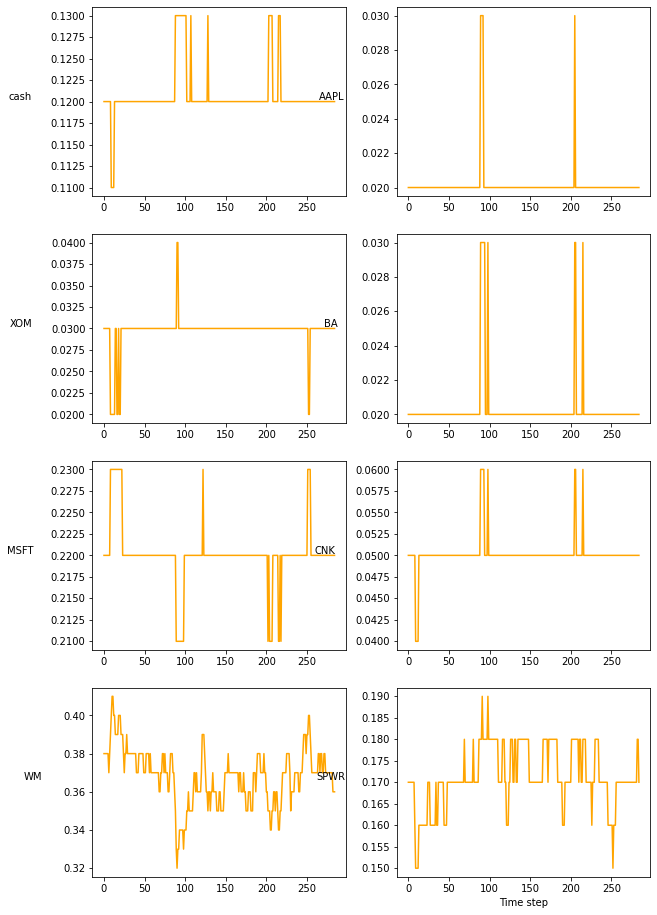

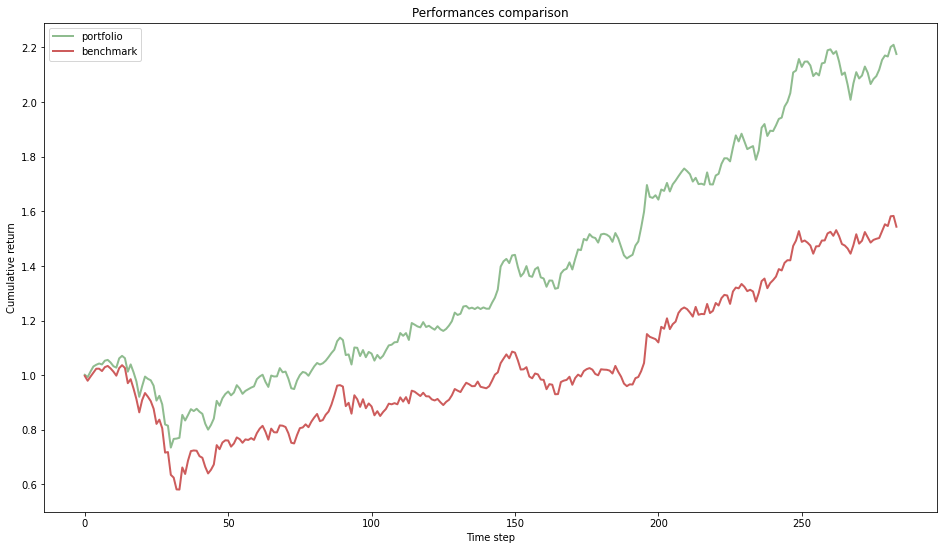

                       strategy  benchmark
PnL                    1.175939   0.543587
Daily Mean Arithmetic  0.002973   0.001890
Volatility             0.021985   0.027083
Max 10 days draw down  0.353608   0.555372
Skewness              -0.017023   0.193636
Kurtosis               3.841620   4.868020
VaR                   -0.027149  -0.036303


In [60]:
param = {'action_bias_var': 0.6423871378823012,
  'actor_learning_rate': 0.001288245020720534,
  'batch size': int(65.5819920303029),
  'critic_learning_rate': 0.004777839405171773,
  'gamma': 0.989069388665919,
  'tau': 0.0001,
  'window_length': 5}

param['episode'] = 20
param['buffer size'] = 100000
param['max step'] = history.shape[1] - 60
param['seed'] = 49
param['predictor_type'] = 'lstm'


nb_classes = len(abbreviation)
action_bound = 1.
use_batch_norm = True
para = param
print(para)

environ = PortfolioEnv(history, abbreviation, steps=history.shape[1] - 200, window_length=para['window_length'])

tf.compat.v1.reset_default_graph()
sess = tf.compat.v1.Session()
tflearn.config.init_training_mode()
action_dim = [nb_classes + 1]
state_dim = [nb_classes + 1, para['window_length'], 3]
variable_scope = get_variable_scope(para['window_length'], para['predictor_type'], use_batch_norm)

with tf.compat.v1.variable_scope(variable_scope):
    actor = StockActor(sess, state_dim, action_dim, action_bound, para['actor_learning_rate'], para['tau'], para['batch size'], para['predictor_type'], use_batch_norm)
    critic = StockCritic(sess=sess, state_dim=state_dim, action_dim=action_dim, tau=para['tau'],
                         learning_rate=para['critic_learning_rate'], num_actor_vars=actor.get_num_trainable_vars(),
                         predictor_type=para['predictor_type'], use_batch_norm=use_batch_norm)

    model_save_path = "weights/"
    summary_path = get_result_path(para['window_length'], para['predictor_type'], use_batch_norm)

    ddpg_model = DDPG(environ, sess, actor, critic, para, obsNormalizer=obs_normalizer, action_bais_var=para['action_bias_var'],
                      model_save_path=model_save_path,
                      summary_path=summary_path)
    ddpg_model.initialize(load_weights=False, verbose=False)
    ddpg_model.train()


print('Build test env')
env_test = PortfolioEnv(future, abbreviation, steps=future.shape[1] - 50, window_length=para['window_length'])
print('Start test')
test_model(env_test, ddpg_model)


def plot_weights(env_infos):
    weights_change = np.empty((nb_classes + 1, len(env_infos)))
    for i in range(len(env_infos)):
        weights_change[:, i] = env_infos[i]['weights']
    long_position = list(abbreviation)
    ylabel = ['cash'] + long_position
    plt.figure(figsize=(10, 16))
    plt.title('Weights change')
    for i in range(nb_classes + 1):
        plt.subplot(int((nb_classes + 2)/2), 2, i + 1)
        plt.plot(np.round(weights_change[i, :], decimals=2), color='orange')
        h = plt.ylabel(ylabel[i], fontsize=10, labelpad=30)
        h.set_rotation(0)
    plt.xlabel('Time step')
    plt.savefig('./plot/Weights - batch_size{0} window_length{1} {2} episode{3} actor_lr{4} critic_lr{5}.jpg'.
                format(para['batch size'], para['window_length'], para['predictor_type'],
                       para['episode'], para['actor_learning_rate'], para['critic_learning_rate']))
    plt.show()


def plot_portfolio(env_infos):
    portfolio, benchmark = [], []
    port, bench = (1 + env_infos[0]['rate_of_return']), env_infos[0]['return']
    for i in range(1, len(env_infos)):
        port *= (1 + env_infos[i]['rate_of_return'])
        bench *= env_infos[i]['return']
        portfolio.append(port)
        benchmark.append(bench)

    plt.figure(figsize=(16, 9))
    plt.title('Performances comparison')
    plt.plot(portfolio, color='darkseagreen', label='portfolio', lw=2.)
    plt.plot(benchmark, color='indianred', label='benchmark', lw=2.)
    plt.ylabel('Cumulative return')
    plt.xlabel('Time step')
    plt.legend()
    plt.savefig('./plot/performance - batch_size{0} window_length{1} {2} episode{3} actor_lr{4} critic_lr{5}.jpg'.
                format(para['batch size'], para['window_length'], para['predictor_type'],
                       para['episode'], para['actor_learning_rate'], para['critic_learning_rate']))
    plt.show()


plot_weights(env_test.infos)
plot_portfolio(env_test.infos)

bench_m, port_f = [], []
for i in range(len(env_test.infos)):
    bench_m.append(env_test.infos[i]['return'])


for i in range(len(env_test.infos)):
    port_f.append(env_test.infos[i]['rate_of_return'])

df = output_statistics(port_f, bench_m)
print(df)



In [24]:
param = {'action_bias_var': 0.6423871378823012,
  'actor_learning_rate': 0.001288245020720534,
  'batch size': int(65.5819920303029),
  'critic_learning_rate': 0.004777839405171773,
  'gamma': 0.989069388665919,
  'tau': 0.0001,
  'window_length': 5}

param['episode'] = 20
param['buffer size'] = 100000
param['max step'] = history.shape[1] - 60
param['seed'] = 49
param['predictor_type'] = 'lstm'


nb_classes = len(abbreviation)
action_bound = 1.
use_batch_norm = True
para = param
print(para)

environ = PortfolioEnv(history, abbreviation, steps=history.shape[1] - 200, window_length=para['window_length'])

tf.compat.v1.reset_default_graph()
sess = tf.compat.v1.Session()
tflearn.config.init_training_mode()
action_dim = [nb_classes + 1]
state_dim = [nb_classes + 1, para['window_length'], 3]
variable_scope = get_variable_scope(para['window_length'], para['predictor_type'], use_batch_norm)

with tf.compat.v1.variable_scope(variable_scope):
    actor = StockActor(sess, state_dim, action_dim, action_bound, para['actor_learning_rate'], para['tau'], para['batch size'], para['predictor_type'], use_batch_norm)
    critic = StockCritic(sess=sess, state_dim=state_dim, action_dim=action_dim, tau=para['tau'],
                         learning_rate=para['critic_learning_rate'], num_actor_vars=actor.get_num_trainable_vars(),
                         predictor_type=para['predictor_type'], use_batch_norm=use_batch_norm)

    model_save_path = "weights/"
    summary_path = get_result_path(para['window_length'], para['predictor_type'], use_batch_norm)

    ddpg_model = DDPG(environ, sess, actor, critic, para, obsNormalizer=obs_normalizer, action_bais_var=para['action_bias_var'],
                      model_save_path=model_save_path,
                      summary_path=summary_path)
    ddpg_model.initialize(load_weights=False, verbose=False)
    ddpg_model.train()


print('Build test env')
env_test = PortfolioEnv(future, abbreviation, steps=future.shape[1] - 50, window_length=para['window_length'])
print('Start test')
test_model(env_test, ddpg_model)


{'action_bias_var': 0.6423871378823012, 'actor_learning_rate': 0.001288245020720534, 'batch size': 65, 'critic_learning_rate': 0.004777839405171773, 'gamma': 0.989069388665919, 'tau': 0.0001, 'window_length': 5, 'episode': 20, 'buffer size': 100000, 'max step': 1198, 'seed': 49, 'predictor_type': 'lstm'}
Build model from scratch
20 episode in all.
[0.1264, 0.13, 0.122, 0.118, 0.1247, 0.1214, 0.1199, 0.1376]
[0.172, 0.1315, 0.1977, 0.028, 0.0451, 0.0489, 0.0581, 0.3186]
[0.1708, 0.127, 0.2088, 0.0196, 0.0339, 0.0371, 0.0462, 0.3566]
[0.1722, 0.1277, 0.208, 0.0208, 0.0354, 0.0387, 0.0481, 0.3491]
Episode: 0, Reward: -1.04, Qmax: 0.0010
[0.1719, 0.1279, 0.209, 0.021, 0.0356, 0.0389, 0.0481, 0.3476]
[0.1722, 0.1276, 0.2084, 0.0206, 0.0351, 0.0384, 0.0477, 0.3499]
[0.1706, 0.1255, 0.2098, 0.0178, 0.0316, 0.035, 0.0435, 0.3663]
[0.1705, 0.1262, 0.2087, 0.0187, 0.0328, 0.0359, 0.0449, 0.3623]
Episode: 1, Reward: -0.77, Qmax: 0.0013
[0.1712, 0.1276, 0.2088, 0.0205, 0.0351, 0.0382, 0.0476, 0.35

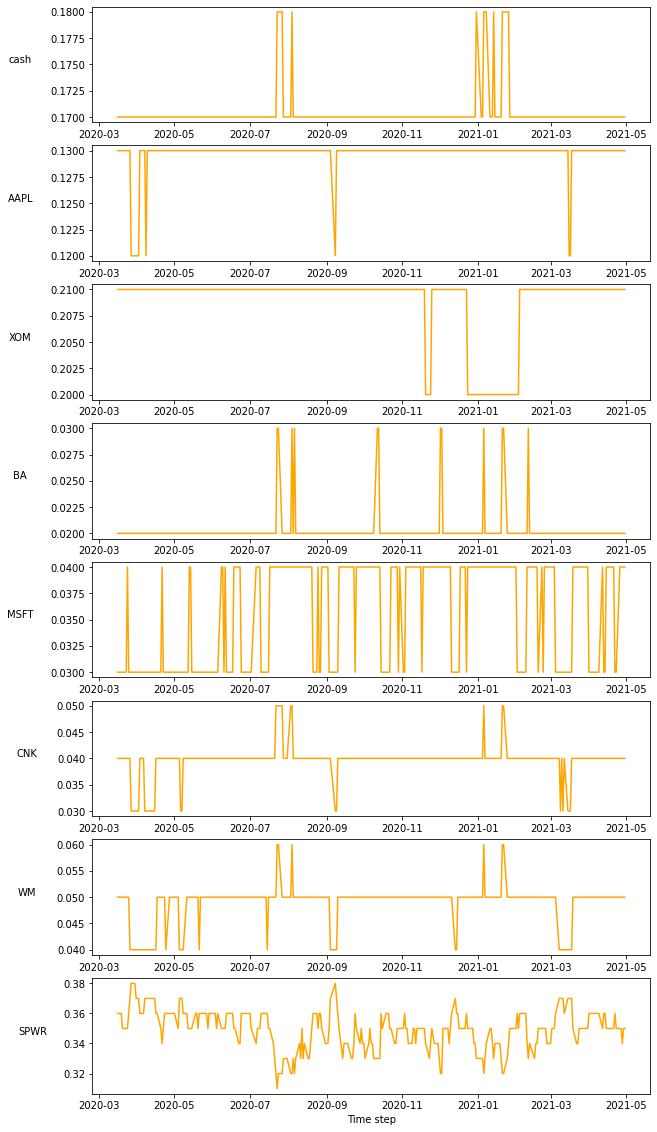

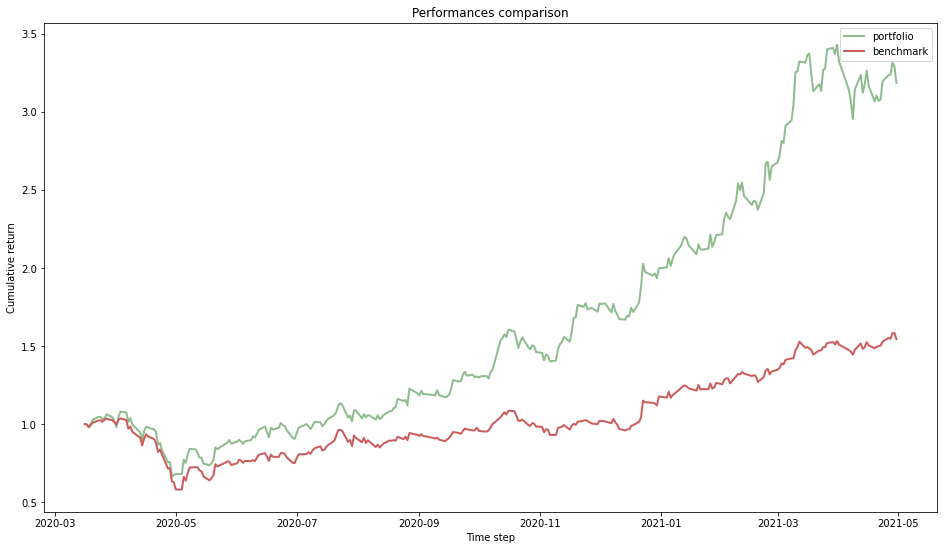

                       strategy  benchmark
PnL                    2.183725   0.543587
Daily Mean Arithmetic  0.004560   0.001890
Volatility             0.031360   0.027083
Max 10 days draw down  0.475551   0.555372
Skewness               0.234451   0.193636
Kurtosis               2.002277   4.868020
VaR                   -0.037945  -0.036303


In [36]:

def plot_weights(env_infos):
    weights_change = np.empty((nb_classes + 1, len(env_infos)))
    for i in range(len(env_infos)):
        weights_change[:, i] = env_infos[i]['weights']
    long_position = list(abbreviation)
    date_data = data.DataReader('AAPL', "yahoo", '2020-01-01', '2021-04-30')
    date = date_data.index[-len(env_infos):]
    ylabel = ['cash'] + long_position
    plt.figure(figsize=(10, 20))
    plt.title('Weights change')
    for i in range(nb_classes + 1):
        plt.subplot(nb_classes + 1, 1, i + 1)
        plt.plot(date, np.round(weights_change[i, :], decimals=2), color='orange')
        h = plt.ylabel(ylabel[i], fontsize=10, labelpad=30)
        # plt.xticks(pd.date_range('2020-01-01','2021-04-30',freq='50d')) 
        h.set_rotation(0)
    plt.xlabel('Time step')
    plt.savefig('./plot/Weights - batch_size{0} window_length{1} {2} episode{3} actor_lr{4} critic_lr{5}.jpg'.
                format(para['batch size'], para['window_length'], para['predictor_type'],
                       para['episode'], para['actor_learning_rate'], para['critic_learning_rate']))
    plt.show()


def plot_portfolio(env_infos):
    portfolio, benchmark = [1], [1]
    port, bench = (1 + env_infos[0]['rate_of_return']), env_infos[0]['return']
    for i in range(1, len(env_infos)):
        port *= (1 + env_infos[i]['rate_of_return'])
        bench *= env_infos[i]['return']
        portfolio.append(port)
        benchmark.append(bench)
    date_data = data.DataReader('AAPL', "yahoo", '2020-01-01', '2021-04-30')
    date = date_data.index[-len(env_infos):]
                                 
    plt.figure(figsize=(16, 9))
    plt.title('Performances comparison')
    plt.plot(date, portfolio, color='darkseagreen', label='portfolio', lw=2.)
    plt.plot(date, benchmark, color='indianred', label='benchmark', lw=2.)  
    plt.ylabel('Cumulative return')
    plt.xlabel('Time step')
    plt.legend()
    plt.savefig('./plot/performance - batch_size{0} window_length{1} {2} episode{3} actor_lr{4} critic_lr{5}.jpg'.
                format(para['batch size'], para['window_length'], para['predictor_type'],
                       para['episode'], para['actor_learning_rate'], para['critic_learning_rate']))
    plt.show()



plot_weights(env_test.infos)
plot_portfolio(env_test.infos)

bench_m, port_f = [], []
for i in range(len(env_test.infos)):
    bench_m.append(env_test.infos[i]['return'])


for i in range(len(env_test.infos)):
    port_f.append(env_test.infos[i]['rate_of_return'])

df = output_statistics(port_f, bench_m)
print(df)

In [ ]:
param = {'action_bias_var': 0.6423871378823012,
  'actor_learning_rate': 0.001288245020720534,
  'batch size': int(65.5819920303029),
  'critic_learning_rate': 0.004777839405171773,
  'gamma': 0.989069388665919,
  'tau': 0.0001,
  'window_length': 5}

param['episode'] = 20
param['buffer size'] = 100000
param['max step'] = history.shape[1] - 60
param['seed'] = 49
param['predictor_type'] = 'lstm'


nb_classes = len(abbreviation)
action_bound = 1.
use_batch_norm = True
para = param
print(para)

environ = PortfolioEnv(history, abbreviation, steps=history.shape[1] - 200, window_length=para['window_length'])

tf.compat.v1.reset_default_graph()
sess = tf.compat.v1.Session()
tflearn.config.init_training_mode()
action_dim = [nb_classes + 1]
state_dim = [nb_classes + 1, para['window_length'], 3]
variable_scope = get_variable_scope(para['window_length'], para['predictor_type'], use_batch_norm)

with tf.compat.v1.variable_scope(variable_scope):
    actor = StockActor(sess, state_dim, action_dim, action_bound, para['actor_learning_rate'], para['tau'], para['batch size'], para['predictor_type'], use_batch_norm)
    critic = StockCritic(sess=sess, state_dim=state_dim, action_dim=action_dim, tau=para['tau'],
                         learning_rate=para['critic_learning_rate'], num_actor_vars=actor.get_num_trainable_vars(),
                         predictor_type=para['predictor_type'], use_batch_norm=use_batch_norm)

    model_save_path = "weights/"
    summary_path = get_result_path(para['window_length'], para['predictor_type'], use_batch_norm)

    ddpg_model = DDPG(environ, sess, actor, critic, para, obsNormalizer=obs_normalizer, action_bais_var=para['action_bias_var'],
                      model_save_path=model_save_path,
                      summary_path=summary_path)
    ddpg_model.initialize(load_weights=False, verbose=False)
    ddpg_model.train()


print('Build test env')
env_test = PortfolioEnv(future, abbreviation, steps=future.shape[1] - 50, window_length=para['window_length'])
print('Start test')
test_model(env_test, ddpg_model)



In [47]:
pf, bm = [1], [1]
port, bench = (1 + env_test.infos[0]['rate_of_return']), env_test.infos[0]['return']
for i in range(1, len(env_test.infos)):
    port *= (1 + env_test.infos[i]['rate_of_return'])
    bench *= env_test.infos[i]['return']
    pf.append(port)
    bm.append(bench)

out = pd.DataFrame(data = [bm, pf]).T
out.columns = ['Stock average', 'DDPG Portfolio']
date_data = data.DataReader('AAPL', "yahoo", '2020-01-01', '2021-04-30')
out.index = date_data.index[-len(env_test.infos):]
out.to_csv('DDPG.csv')


In [60]:
df = output_statistics(port_f, bench_m)
print(df)

                       strategy  benchmark
PnL                    0.978292   0.543587
Daily Mean Arithmetic  0.002718   0.001890
Volatility             0.025521   0.027083
Max 10 days draw down  0.434058   0.555372
Skewness               0.770091   0.193636
Kurtosis               7.676851   4.868020
VaR                   -0.032657  -0.036303


{'VAR': 0.5600000000000002, 'actor_learning_rate': 0.002, 'batch size': 432, 'buffer size': 100000, 'critic_learning_rate': 0.001, 'episode': 32, 'gamma': 0.99, 'max step': 2204, 'predictor_type': 'cnn', 'seed': 49, 'tau': 0.001, 'window_length': 23}
Build model from scratch
32 episode in all.
[0.1458, 0.1749, 0.1379, 0.1894, 0.2064, 0.1455]
[0.1589, 0.1749, 0.1154, 0.1901, 0.1746, 0.1861]
[0.1421, 0.1892, 0.0926, 0.1935, 0.1837, 0.1989]
[0.1793, 0.1668, 0.1232, 0.1886, 0.1684, 0.1737]
[0.1632, 0.1647, 0.1163, 0.1873, 0.1731, 0.1953]
[0.1401, 0.1774, 0.1203, 0.1956, 0.1997, 0.167]
Episode: 0, Reward: 0.61, Qmax: 0.0000
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'NoneType' object has no attribute 'name'
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'NoneType' object has no attribute 'name'
[0.1314, 

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


[0.155, 0.1802, 0.1096, 0.1942, 0.1865, 0.1745]
[0.1895, 0.1625, 0.1215, 0.1948, 0.1637, 0.1679]
[0.1705, 0.1805, 0.1114, 0.2123, 0.1857, 0.1396]
[0.168, 0.175, 0.1254, 0.1691, 0.1702, 0.1923]
[0.1975, 0.1599, 0.1355, 0.1956, 0.1483, 0.1631]
Episode: 1, Reward: 0.89, Qmax: 0.0000
[0.1325, 0.1974, 0.1162, 0.1806, 0.2109, 0.1623]
[0.1684, 0.1831, 0.1144, 0.2013, 0.1804, 0.1524]
[0.13, 0.2, 0.0998, 0.1849, 0.2035, 0.1818]
[0.161, 0.1858, 0.0997, 0.1829, 0.1773, 0.1932]
[0.1488, 0.1745, 0.1272, 0.1914, 0.1763, 0.1818]
[0.1816, 0.146, 0.1384, 0.2035, 0.1623, 0.1682]
Episode: 2, Reward: 0.83, Qmax: 0.0000
[0.1583, 0.1797, 0.1126, 0.1877, 0.1874, 0.1743]
[0.1718, 0.1825, 0.1044, 0.1803, 0.1725, 0.1885]
[0.1642, 0.1673, 0.1307, 0.1864, 0.1699, 0.1815]
[0.1508, 0.1815, 0.1016, 0.2002, 0.1722, 0.1936]
[0.1458, 0.1897, 0.1057, 0.1974, 0.1776, 0.1837]
[0.1545, 0.168, 0.1323, 0.1939, 0.1668, 0.1845]
Episode: 3, Reward: 0.35, Qmax: 0.0000
[0.1725, 0.1856, 0.1064, 0.1738, 0.1735, 0.1882]
[0.1262, 0.1

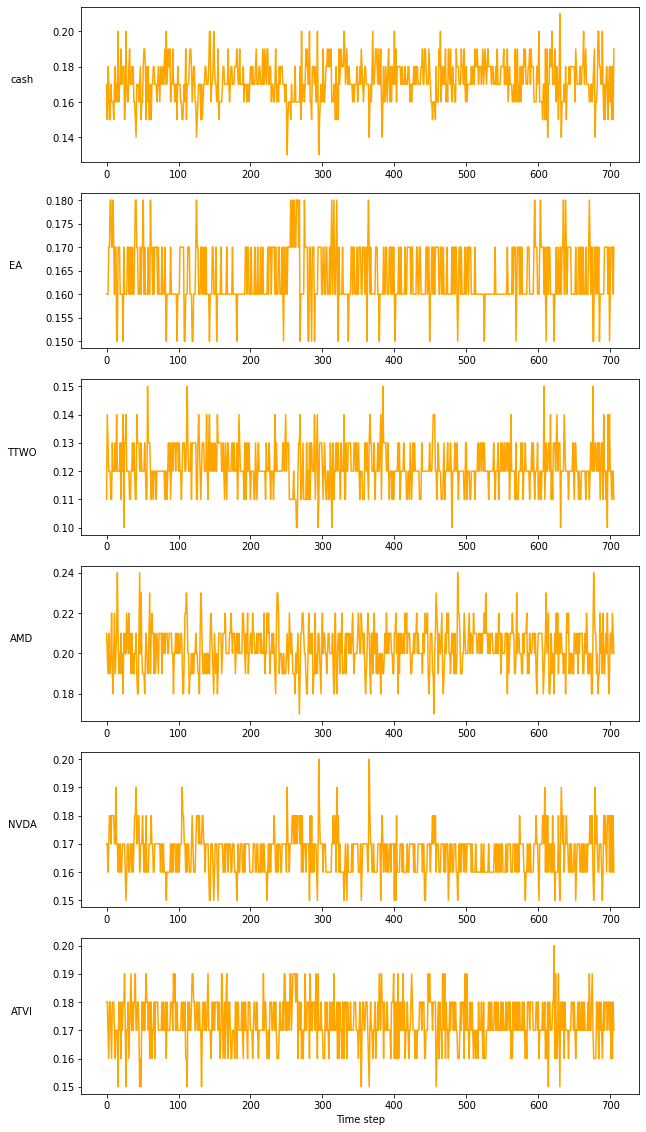

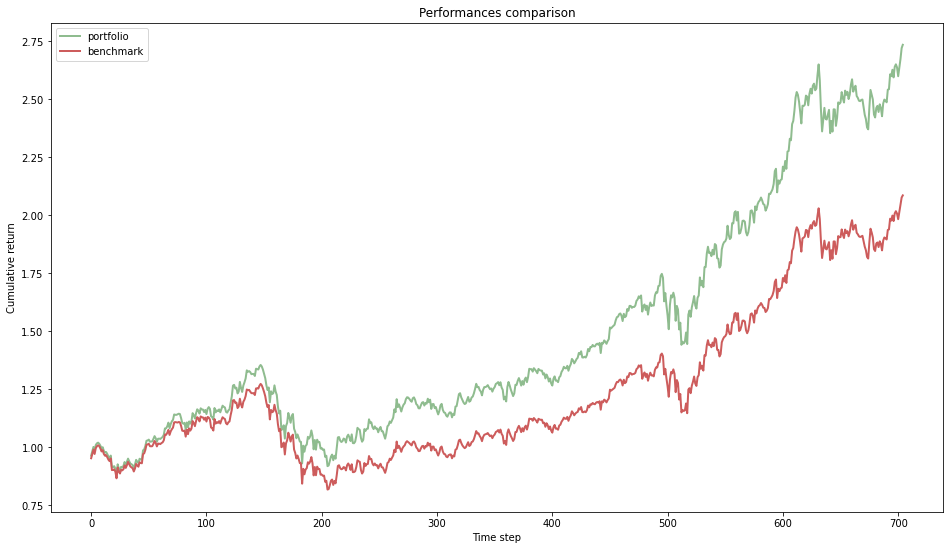

                       strategy  benchmark
PnL                    1.733046   1.084592
Daily Mean Arithmetic  0.001604   0.001214
Volatility             0.018928   0.018565
Max 10 days draw down  0.228740   0.250432
Skewness              -0.123648  -0.247342
Kurtosis               2.557432   2.805806
VaR                   -0.027363  -0.027583


In [ ]:
abbreviation = ['EA', 'TTWO', 'AMD', 'NVDA', 'ATVI']
history = data_process(abbreviation, '2011-01-01', '2017-12-31')
future = data_process(abbreviation, '2018-01-01', '2020-12-31')

random_grid = {
    'episode': list(np.arange(16, 48, 4)),
    'batch size': list(np.arange(16, 513, 4)),
    'window_length': list(np.arange(10, 31, 1)),
    'predictor_type': ['lstm', 'cnn'],
    'actor_learning_rate': list(np.arange(0.0001, 0.01, 0.0003)),
    'critic_learning_rate': np.arange(0.0001, 0.01, 0.0003),
    'VAR': list(np.arange(0.05, 0.8, 0.01)),
    'gamma': list(np.arange(0.95, 1, 0.01)),
    "buffer size": [100000],
    "max step": [history.shape[1] - 60],
    "tau": [0.001],
    "seed": [49]
}

ind = 44
para = {}
vals = {'VAR': 51, 'actor_learning_rate': 25, 'batch size': 7, 'buffer size': 0, 'critic_learning_rate': 13,
        'episode': 7, 'gamma': 4, 'max step': 0, 'predictor_type': 1, 'seed': 0, 'tau': 0, 'window_length': 8}

for i in range(len(vals)):
    para[list(vals.keys())[i]] = random_grid[list(vals.keys())[i]][list(vals.values())[i]]



nb_classes = len(abbreviation)
action_bound = 1.
tau = 1e-4
use_batch_norm = True
# para['tau'] = tau
para['episode'] = 32
para['batch size'] = 432
para['actor_learning_rate'] = 0.002
para['critic_learning_rate'] = 0.001
para['window_length'] = 23
print(para)

environ = PortfolioEnv(history, abbreviation, steps=history.shape[1] - 200, window_length=para['window_length'])

tf.compat.v1.reset_default_graph()
sess = tf.compat.v1.Session()
tflearn.config.init_training_mode()
action_dim = [nb_classes + 1]
state_dim = [nb_classes + 1, para['window_length'], 3]
variable_scope = get_variable_scope(para['window_length'], para['predictor_type'], use_batch_norm)

with tf.compat.v1.variable_scope(variable_scope):
    actor = StockActor(sess, state_dim, action_dim, action_bound, para['actor_learning_rate'], para['tau'] ,
                       para['batch size'], para['predictor_type'], use_batch_norm)
    critic = StockCritic(sess=sess, state_dim=state_dim, action_dim=action_dim, tau=1e-3,
                         learning_rate=para['critic_learning_rate'], num_actor_vars=actor.get_num_trainable_vars(),
                         predictor_type=para['predictor_type'], use_batch_norm=use_batch_norm)

    model_save_path = "weights/"
    summary_path = get_result_path(para['window_length'], para['predictor_type'], use_batch_norm)

    ddpg_model = DDPG(environ, sess, actor, critic, para, obsNormalizer=obs_normalizer, action_bais_var=para['VAR'],
                      model_save_path=model_save_path,
                      summary_path=summary_path)
    ddpg_model.initialize(load_weights=False, verbose=False)
    ddpg_model.train()


print('Build test env')
env_test = PortfolioEnv(future, abbreviation, steps=future.shape[1] - 50, window_length=para['window_length'])
print('Start test')
test_model(env_test, ddpg_model)


def plot_weights(env_infos):
    weights_change = np.empty((nb_classes + 1, len(env_infos)))
    for i in range(len(env_infos)):
        weights_change[:, i] = env_infos[i]['weights']
    long_position = list(abbreviation)
    ylabel = ['cash'] + long_position
    plt.figure(figsize=(10, 20))
    plt.title('Weights change')
    for i in range(nb_classes + 1):
        plt.subplot(nb_classes + 1, 1, i + 1)
        plt.plot(np.round(weights_change[i, :], decimals=2), color='orange')
        h = plt.ylabel(ylabel[i], fontsize=10, labelpad=30)
        h.set_rotation(0)
    plt.xlabel('Time step')
    plt.savefig('./plot/Weights - batch_size{0} window_length{1} {2} episode{3} actor_lr{4} critic_lr{5}.jpg'.
                format(para['batch size'], para['window_length'], para['predictor_type'],
                       para['episode'], para['actor_learning_rate'], para['critic_learning_rate']))
    plt.show()


def plot_portfolio(env_infos):
    portfolio, benchmark = [], []
    port, bench = (1 + env_infos[0]['rate_of_return']), env_infos[0]['return']
    for i in range(1, len(env_infos)):
        port *= (1 + env_infos[i]['rate_of_return'])
        bench *= env_infos[i]['return']
        portfolio.append(port)
        benchmark.append(bench)

    plt.figure(figsize=(16, 9))
    plt.title('Performances comparison')
    plt.plot(portfolio, color='darkseagreen', label='portfolio', lw=2.)
    plt.plot(benchmark, color='indianred', label='benchmark', lw=2.)
    plt.ylabel('Cumulative return')
    plt.xlabel('Time step')
    plt.legend()
    plt.savefig('./plot/performance - batch_size{0} window_length{1} {2} episode{3} actor_lr{4} critic_lr{5}.jpg'.
                format(para['batch size'], para['window_length'], para['predictor_type'],
                       para['episode'], para['actor_learning_rate'], para['critic_learning_rate']))
    plt.show()


plot_weights(env_test.infos)
plot_portfolio(env_test.infos)

bench_m, port_f = [], []
for i in range(len(env_test.infos)):
    bench_m.append(env_test.infos[i]['return'])


for i in range(len(env_test.infos)):
    port_f.append(env_test.infos[i]['rate_of_return'])

df = output_statistics(port_f, bench_m)
print(df)


In [ ]:


def plot_weights(env_infos):
    weights_change = np.empty((nb_classes + 1, len(env_infos)))
    for i in range(len(env_infos)):
        weights_change[:, i] = env_infos[i]['weights']
    long_position = list(abbreviation)
    ylabel = ['cash'] + long_position
    plt.figure(figsize=(10, 20))
    plt.title('Weights change')
    for i in range(nb_classes + 1):
        plt.subplot(nb_classes + 1, 1, i + 1)
        plt.plot(np.round(weights_change[i, :], decimals=2), color='orange')
        h = plt.ylabel(ylabel[i], fontsize=10, labelpad=30)
        h.set_rotation(0)
    plt.xlabel('Time step')
    plt.savefig('./plot/Weights - batch_size{0} window_length{1} {2} episode{3} actor_lr{4} critic_lr{5}.jpg'.
                format(para['batch size'], para['window_length'], para['predictor_type'],
                       para['episode'], para['actor_learning_rate'], para['critic_learning_rate']))
    plt.show()



def plot_portfolio(env_infos):
    portfolio, benchmark = [], []
    port, bench = (1 + env_infos[0]['rate_of_return']), env_infos[0]['return']
    for i in range(1, len(env_infos)):
        port *= (1 + env_infos[i]['rate_of_return'])
        bench *= env_infos[i]['return']
        portfolio.append(port)
        benchmark.append(bench)

    plt.figure(figsize=(16, 9))
    plt.title('Performances comparison')
    plt.plot(portfolio, color='darkseagreen', label='portfolio', lw=2.)
    plt.plot(benchmark, color='indianred', label='benchmark', lw=2.)
    plt.ylabel('Cumulative return')
    plt.xlabel('Time step')
    plt.legend()
    plt.savefig('./plot/profits - batch_size{0} window_length{1} {2} episode{3} actor_lr{4} critic_lr{5}.jpg'.
                format(para['batch size'], para['window_length'], para['predictor_type'],
                       para['episode'], para['actor_learning_rate'], para['critic_learning_rate']))
    plt.show()


Build test env
Start test


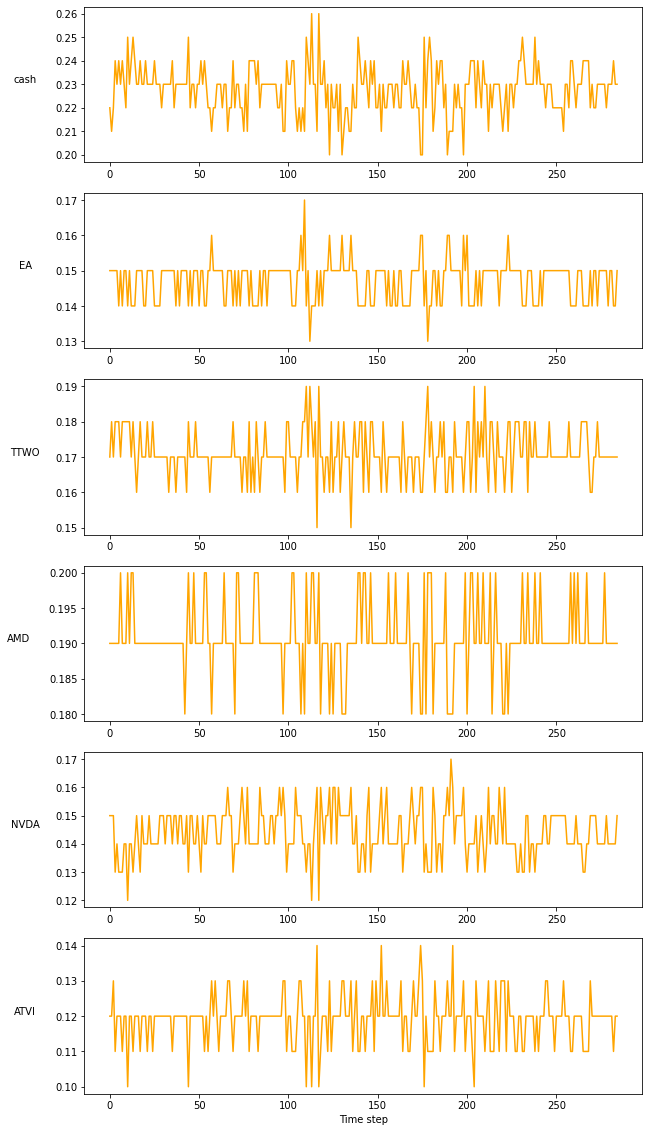

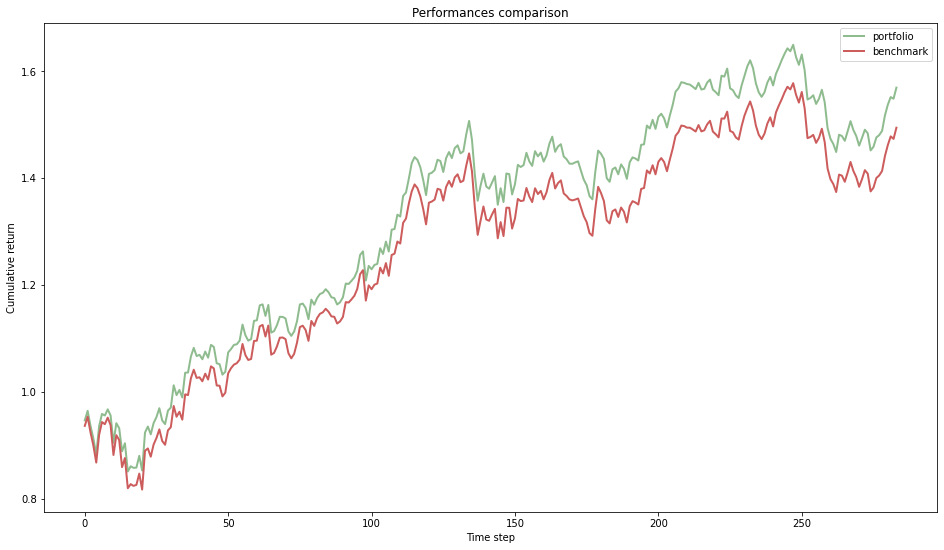

In [ ]:
print('Build test env')
env_test = PortfolioEnv(future, abbreviation, steps=future.shape[1] - 50, window_length=para['window_length'])
print('Start test')
test_model(env_test, ddpg_model)
plot_weights(env_test.infos)
plot_portfolio(env_test.infos)

In [ ]:
# weights_c = np.empty((nb_classes+1, len(env_test.infos)))
# for i in range(len(env_test.infos)):
#     weights_c[:, i] = env_test.infos[i]['weights']

In [ ]:
from scipy import stats

bench_m, port_f = [], []
for i in range(len(env_test.infos)):
    bench_m.append(env_test.infos[i]['return'])


for i in range(len(env_test.infos)):
    port_f.append(env_test.infos[i]['rate_of_return'])

df = output_statistics(port_f, bench_m)
print(df)

                       strategy  benchmark
PnL                    1.156796   0.634478
Daily Mean Arithmetic  0.004150   0.002606
Volatility             0.026784   0.019148
Max 10 days draw down  0.225343   0.140535
Skewness               0.189628  -0.031032
Kurtosis               0.656651   2.369298
VaR                   -0.035332  -0.026374


Build test env
Start test


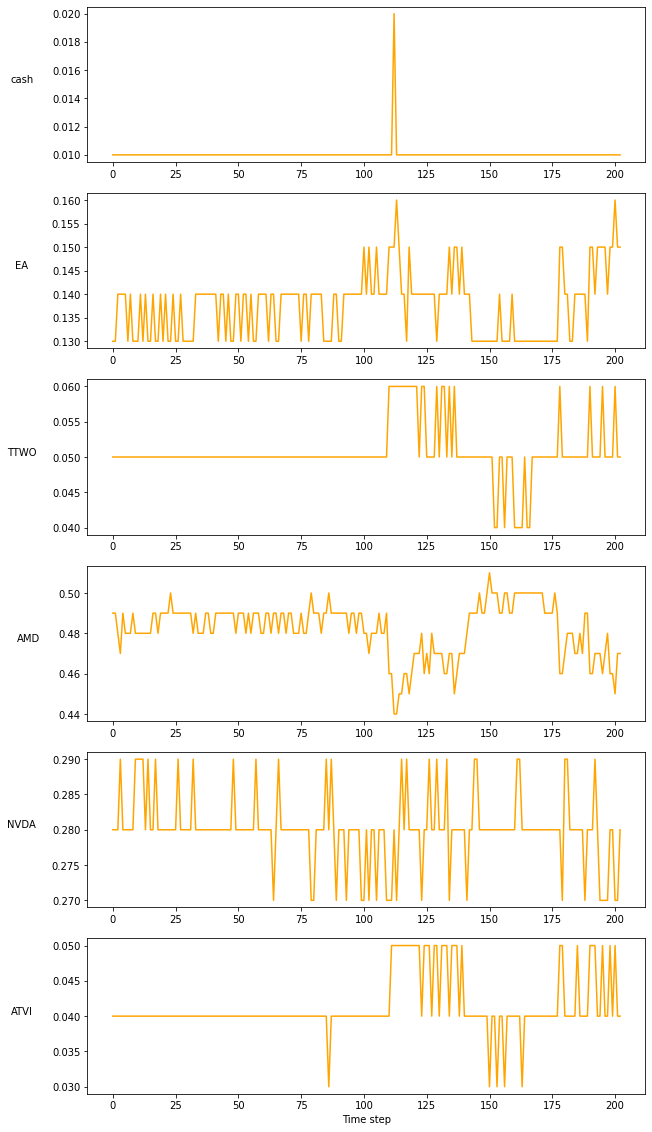

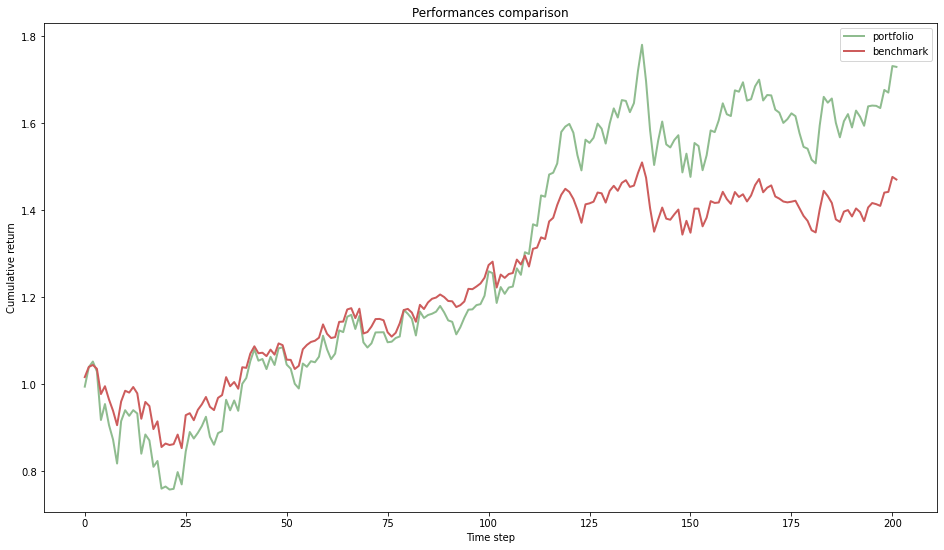

In [ ]:
print('Build test env')
env_test = PortfolioEnv(future, abbreviation, steps=future.shape[1] - 50, window_length=para['window_length'])
print('Start test')
test_model(env_test, ddpg_model)
plot_weights(env_test.infos)
plot_portfolio(env_test.infos)

In [ ]:
from scipy import stats

bench_m, port_f = [], []
for i in range(len(env_test.infos)):
    bench_m.append(env_test.infos[i]['return'])


for i in range(len(env_test.infos)):
    port_f.append(env_test.infos[i]['rate_of_return'])

df = output_statistics(port_f, bench_m)
print(df)

                       strategy  benchmark
PnL                    0.625746   0.556525
Daily Mean Arithmetic  0.001850   0.001717
Volatility             0.016940   0.018066
Max 10 days draw down  0.139980   0.144119
Skewness               0.002129  -0.094070
Kurtosis               2.370634   2.604587
VaR                   -0.023608  -0.023954


In [ ]:
print('Build test env')
env_test = PortfolioEnv(future, abbreviation, steps=future.shape[1] - 50, window_length=para['window_length'])
print('Start test')
test_model(env_test, ddpg_model)
plot_weights(env_test.infos)
plot_portfolio(env_test.infos)

In [ ]:
from scipy import stats

bench_m, port_f = [], []
for i in range(len(env_test.infos)):
    bench_m.append(env_test.infos[i]['return'])


for i in range(len(env_test.infos)):
    port_f.append(env_test.infos[i]['rate_of_return'])

df = output_statistics(port_f, bench_m)
print(df)

                       strategy  benchmark
PnL                    0.711090   0.574301
Daily Mean Arithmetic  0.002024   0.001756
Volatility             0.016622   0.018043
Max 10 days draw down  0.139980   0.140535
Skewness               0.100304  -0.098469
Kurtosis               2.356901   2.632340
VaR                   -0.023344  -0.023954


## Latest

In [71]:
param = {'action_bias_var': 0.6423871378823012,
  'actor_learning_rate': 0.001288245020720534,
  'batch size': int(65.5819920303029),
  'critic_learning_rate': 0.004777839405171773,
  'gamma': 0.989069388665919,
  'tau': 0.0001,
  'window_length': 5}

param['episode'] = 20
param['buffer size'] = 100000
param['max step'] = history.shape[1] - 60
param['seed'] = 49
param['predictor_type'] = 'lstm'


nb_classes = len(abbreviation)
action_bound = 1.
use_batch_norm = True
para = param
print(para)

environ = PortfolioEnv(history, abbreviation, steps=history.shape[1] - 200, window_length=para['window_length'])

tf.compat.v1.reset_default_graph()
sess = tf.compat.v1.Session()
tflearn.config.init_training_mode()
action_dim = [nb_classes + 1]
state_dim = [nb_classes + 1, para['window_length'], 3]
variable_scope = get_variable_scope(para['window_length'], para['predictor_type'], use_batch_norm)

with tf.compat.v1.variable_scope(variable_scope):
    actor = StockActor(sess, state_dim, action_dim, action_bound, para['actor_learning_rate'], para['tau'], para['batch size'], para['predictor_type'], use_batch_norm)
    critic = StockCritic(sess=sess, state_dim=state_dim, action_dim=action_dim, tau=para['tau'],
                         learning_rate=para['critic_learning_rate'], num_actor_vars=actor.get_num_trainable_vars(),
                         predictor_type=para['predictor_type'], use_batch_norm=use_batch_norm)

    model_save_path = "weights/"
    summary_path = get_result_path(para['window_length'], para['predictor_type'], use_batch_norm)

    ddpg_model = DDPG(environ, sess, actor, critic, para, obsNormalizer=obs_normalizer, action_bais_var=para['action_bias_var'],
                      model_save_path=model_save_path,
                      summary_path=summary_path)
    ddpg_model.initialize(load_weights=False, verbose=False)
    ddpg_model.train()


print('Build test env')
env_test = PortfolioEnv(future, abbreviation, steps=future.shape[1] - 50, window_length=para['window_length'])
print('Start test')
test_model(env_test, ddpg_model)



{'action_bias_var': 0.6423871378823012, 'actor_learning_rate': 0.001288245020720534, 'batch size': 65, 'critic_learning_rate': 0.004777839405171773, 'gamma': 0.989069388665919, 'tau': 0.0001, 'window_length': 5, 'episode': 20, 'buffer size': 100000, 'max step': 1198, 'seed': 49, 'predictor_type': 'lstm'}
Build test env
Start test


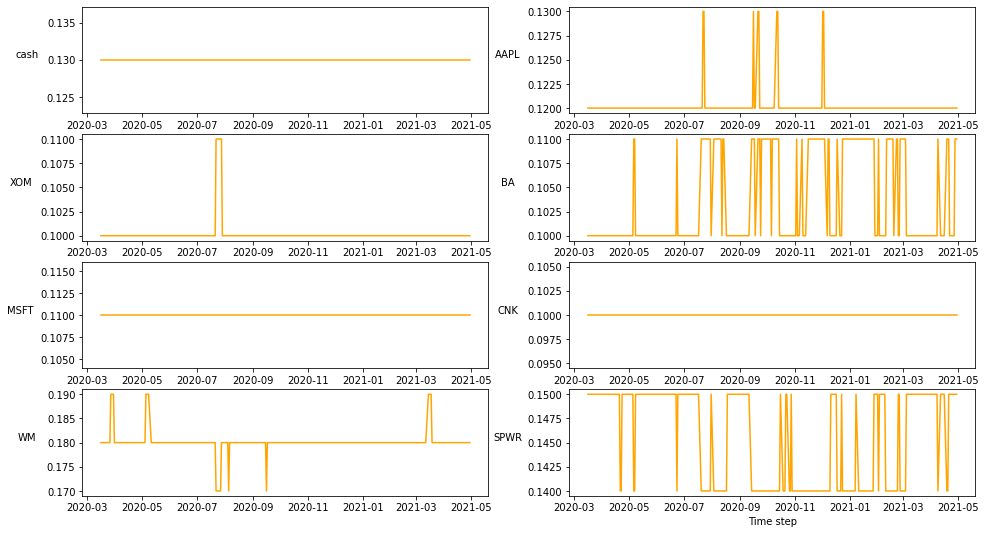

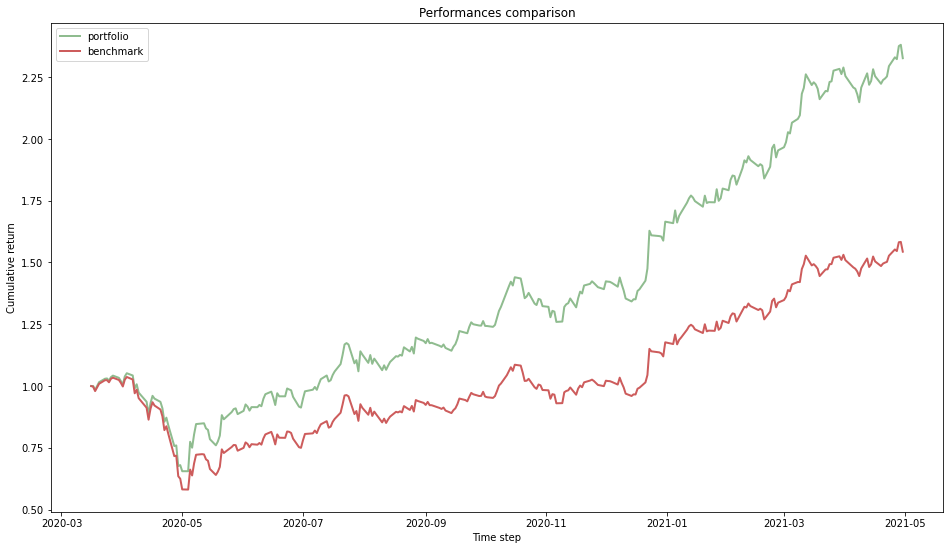

                       strategy  benchmark
PnL                    1.326343   0.543587
Daily Mean Arithmetic  0.003323   0.001890
Volatility             0.026896   0.027083
Max 10 days draw down  0.427924   0.555372
Skewness               0.909773   0.193636
Kurtosis               8.463863   4.868020
VaR                   -0.031979  -0.036303


In [72]:


def plot_weights(env_infos):
    weights_change = np.empty((nb_classes + 1, len(env_infos)))
    date_data = data.DataReader('AAPL', "yahoo", '2020-01-01', '2021-04-30')
    date = date_data.index[-len(env_infos):]
    for i in range(len(env_infos)):
        weights_change[:, i] = env_infos[i]['weights']
    long_position = list(abbreviation)
    ylabel = ['cash'] + long_position
    plt.figure(figsize=(16, 9))
    plt.title('Weights change')
    for i in range(nb_classes + 1):
        plt.subplot(int((nb_classes + 2)/2), 2, i + 1)
        plt.plot(date, np.round(weights_change[i, :], decimals=2), color='orange')
        h = plt.ylabel(ylabel[i], fontsize=10, labelpad=20)
        h.set_rotation(0)
    plt.xlabel('Time step')
    plt.savefig('./plot/Weights - batch_size{0} window_length{1} {2} episode{3} actor_lr{4} critic_lr{5}.jpg'.
                format(para['batch size'], para['window_length'], para['predictor_type'],
                       para['episode'], para['actor_learning_rate'], para['critic_learning_rate']))
    plt.show()


def plot_portfolio(env_infos):
    portfolio, benchmark = [1], [1]
    date_data = data.DataReader('AAPL', "yahoo", '2020-01-01', '2021-04-30')
    date = date_data.index[-len(env_infos):]
    port, bench = (1 + env_infos[0]['rate_of_return']), env_infos[0]['return']
    for i in range(1, len(env_infos)):
        port *= (1 + env_infos[i]['rate_of_return'])
        bench *= env_infos[i]['return']
        portfolio.append(port)
        benchmark.append(bench)

    plt.figure(figsize=(16, 9))
    plt.title('Performances comparison')
    plt.plot(date, portfolio, color='darkseagreen', label='portfolio', lw=2.)
    plt.plot(date, benchmark, color='indianred', label='benchmark', lw=2.)
    plt.ylabel('Cumulative return')
    plt.xlabel('Time step')
    plt.legend()
    plt.savefig('./plot/performance - batch_size{0} window_length{1} {2} episode{3} actor_lr{4} critic_lr{5}.jpg'.
                format(para['batch size'], para['window_length'], para['predictor_type'],
                       para['episode'], para['actor_learning_rate'], para['critic_learning_rate']))
    plt.show()


plot_weights(env_test.infos)
plot_portfolio(env_test.infos)

bench_m, port_f = [], []
for i in range(len(env_test.infos)):
    bench_m.append(env_test.infos[i]['return'])


for i in range(len(env_test.infos)):
    port_f.append(env_test.infos[i]['rate_of_return'])

df = output_statistics(port_f, bench_m)
print(df)





In [ ]:
abbreviation = ['AAPL', 'XOM', 'BA', 'MSFT', 'CNK', 'WM', 'SPWR']
history = data_process(abbreviation, '2015-01-01', '2019-12-31')
future = data_process(abbreviation, '2020-01-01', '2021-04-30')

param = {'action_bias_var': 0.6423871378823012,
  'actor_learning_rate': 0.001288245020720534,
  'batch size': int(65.5819920303029),
  'critic_learning_rate': 0.004777839405171773,
  'gamma': 0.989069388665919,
  'tau': 0.0001,
  'window_length': 5}

param['episode'] = 20
param['buffer size'] = 100000
param['max step'] = history.shape[1] - 60
param['seed'] = 49
param['predictor_type'] = 'lstm'


nb_classes = len(abbreviation)
action_bound = 1.
use_batch_norm = True
para = param
print(para)

environ = PortfolioEnv(history, abbreviation, steps=history.shape[1] - 200, window_length=para['window_length'])

tf.compat.v1.reset_default_graph()
sess = tf.compat.v1.Session()
tflearn.config.init_training_mode()
action_dim = [nb_classes + 1]
state_dim = [nb_classes + 1, para['window_length'], 3]
variable_scope = get_variable_scope(para['window_length'], para['predictor_type'], use_batch_norm)

with tf.compat.v1.variable_scope(variable_scope):
    actor = StockActor(sess, state_dim, action_dim, action_bound, para['actor_learning_rate'], para['tau'], para['batch size'], para['predictor_type'], use_batch_norm)
    critic = StockCritic(sess=sess, state_dim=state_dim, action_dim=action_dim, tau=para['tau'],
                         learning_rate=para['critic_learning_rate'], num_actor_vars=actor.get_num_trainable_vars(),
                         predictor_type=para['predictor_type'], use_batch_norm=use_batch_norm)

    model_save_path = "weights/"
    summary_path = get_result_path(para['window_length'], para['predictor_type'], use_batch_norm)

    ddpg_model = DDPG(environ, sess, actor, critic, para, obsNormalizer=obs_normalizer, action_bais_var=para['action_bias_var'],
                      model_save_path=model_save_path,
                      summary_path=summary_path)
    ddpg_model.initialize(load_weights=False, verbose=False)
    ddpg_model.train()


print('Build test env')
env_test = PortfolioEnv(future, abbreviation, steps=future.shape[1] - 50, window_length=para['window_length'])
print('Start test')
test_model(env_test, ddpg_model)



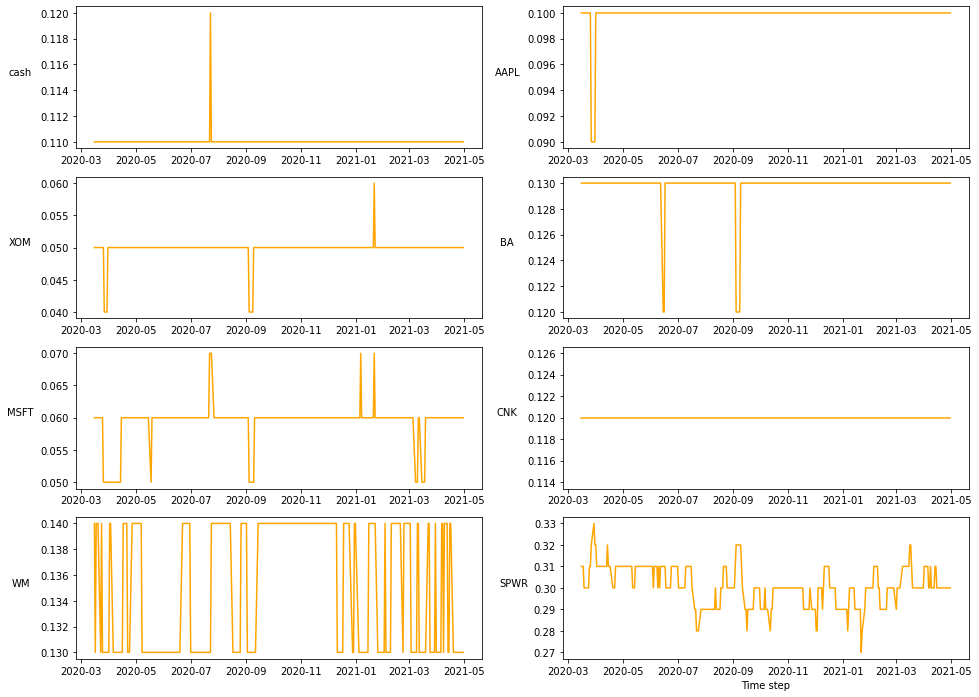

[0.08548618033757513, -0.10942361386958441, 0.05399202302794125, -0.05063296527154561, 0.0021249665933263068, -0.04309411803152155, -0.025568220125682606, 0.0906033071977216, 0.014970191411175787, 0.058389771856422586, -0.02978568980607701, 0.03247571668612709, -0.01490533243000499, -0.04500486638098545, 0.02307541340116112, -0.014454202502154408, 0.06716616310575979, 0.0010195566631873666, 0.03356829773431445, 0.015217328332930513, -0.009130117182301636, 0.029492960664691696, -0.02124817412417234, 0.004824299753158746, 0.027015286850642136, -0.01761785822073327, -0.0303632526066167, 0.02219456355839814, -7.176820868328667e-05, 0.01393880865555609, 0.014418457308456017, -0.004598495030134179, 0.02617844795395519, -0.009310553921011884, -0.026473559797677574, 0.0027583809793749153, 0.00923921874279006, -0.006778652499312557, 0.012066813187580367, 0.0165461797870038, 0.00020505912891645442, -0.01993149842685957, -0.01768588474689787, 0.01196741580741408, 0.004597023038866274, 0.030459465

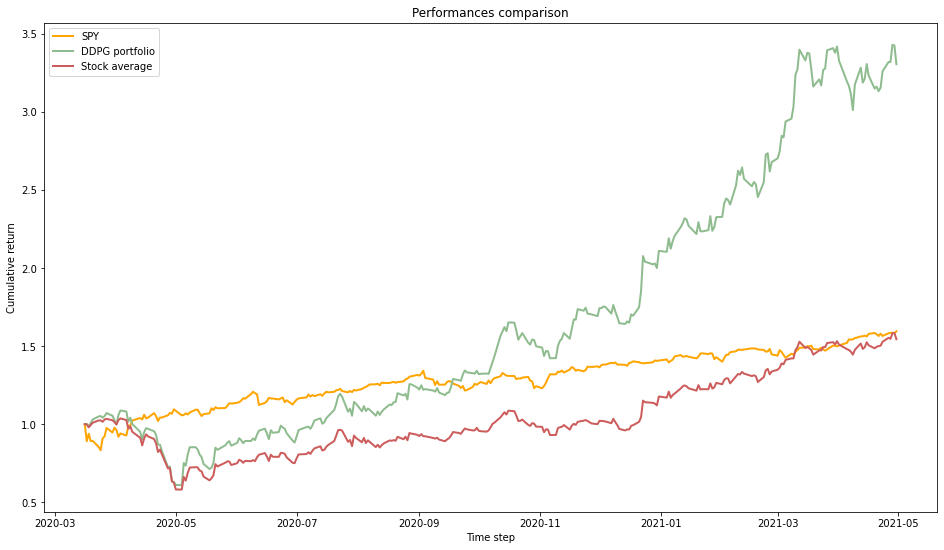

                       strategy  benchmark
PnL                    2.303779   0.543587
Daily Mean Arithmetic  0.004789   0.001890
Volatility             0.034643   0.027083
Max 10 days draw down  0.564351   0.555372
Skewness               0.989107   0.193636
Kurtosis               7.388503   4.868020
VaR                   -0.040121  -0.036303


In [98]:

def plot_weights(env_infos):
    weights_change = np.empty((nb_classes + 1, len(env_infos)))
    date_data = data.DataReader('AAPL', "yahoo", '2020-01-01', '2021-04-30')
    date = date_data.index[-len(env_infos):]
    for i in range(len(env_infos)):
        weights_change[:, i] = env_infos[i]['weights']
    long_position = list(abbreviation)
    ylabel = ['cash'] + long_position
    plt.figure(figsize=(16, 12))
    plt.title('Weights change')
    for i in range(nb_classes + 1):
        plt.subplot(int((nb_classes + 2)/2), 2, i + 1)
        plt.plot(date, np.round(weights_change[i, :], decimals=2), color='orange')
        h = plt.ylabel(ylabel[i], fontsize=10, labelpad=20)
        h.set_rotation(0)
    plt.xlabel('Time step')
    plt.savefig('./plot/Weights - batch_size{0} window_length{1} {2} episode{3} actor_lr{4} critic_lr{5}.jpg'.
                format(para['batch size'], para['window_length'], para['predictor_type'],
                       para['episode'], para['actor_learning_rate'], para['critic_learning_rate']))
    plt.show()


def plot_portfolio(env_infos):
    portfolio, benchmark = [1], [1]
    date_data = data.DataReader('SPY', "yahoo", '2020-01-01', '2021-04-30')
    date = date_data.index[-len(env_infos):]
    port, bench = (1 + env_infos[0]['rate_of_return']), env_infos[0]['return']
    etf_p = 1
    lst_1 = list(date_data['Adj Close'].diff()[-(len(env_infos) + 1):])
    lst_2 = list(date_data['Adj Close'][-(len(env_infos) + 2):-1])
    ETF = [lst_1[k]/lst_2[k] for k in range(len(lst_1))]
    print(ETF)
    ETF_prof = [1]
    for i in range(1, len(env_infos)):
        port *= (1 + env_infos[i]['rate_of_return'])
        bench *= env_infos[i]['return']
        etf_p *= ETF[i] + 1
        portfolio.append(port)
        benchmark.append(bench)
        ETF_prof.append(etf_p)


    plt.figure(figsize=(16, 9))
    plt.title('Performances comparison')
    plt.plot(date, ETF_prof, color='orange', label='SPY', lw=2.)
    plt.plot(date, portfolio, color='darkseagreen', label='DDPG portfolio', lw=2.)
    plt.plot(date, benchmark, color='indianred', label='Stock average', lw=2.)
    plt.ylabel('Cumulative return')
    plt.xlabel('Time step')
    plt.legend()
    plt.savefig('./plot/performance - batch_size{0} window_length{1} {2} episode{3} actor_lr{4} critic_lr{5}.jpg'.
                format(para['batch size'], para['window_length'], para['predictor_type'],
                       para['episode'], para['actor_learning_rate'], para['critic_learning_rate']))
    plt.show()


plot_weights(env_test.infos)
plot_portfolio(env_test.infos)
G
bench_m, port_f = [], []
for i in range(len(env_test.infos)):
    bench_m.append(env_test.infos[i]['return'])


for i in range(len(env_test.infos)):
    port_f.append(env_test.infos[i]['rate_of_return'])

df = output_statistics(port_f, bench_m)
print(df)

